# Table of Contents

[Re-usable functions](#Re-usable-functions)

[Can the data be clustered according to the answers given to the before questionnaire?](#Can-the-data-be-clustered-according-to-the-answers-given-to-the-before-questionnaire?)
  - If scientific questions are coded by answers
  - If scientific questions are coded by correctedness

[Can the data be clustered according to the answers given to the after questionnaire?](#Can-the-data-be-clustered-according-to-the-answers-given-to-the-after-questionnaire?)
  - If scientific questions are coded by answers
  - If scientific questions are coded by correctedness

[Can the data be clustered according to the answers given to the questionnaire?](#Can-the-data-be-clustered-according-to-the-answers-given-to-the-questionnaire?)
  - If scientific questions are coded by answers
    - If only before and after questionnaires are used
    - If all questionnaires are used
  - If scientific questions are coded by correctedness
    - If only before and after questionnaires are used
    - If all questionnaires are used

[Can the data be clustered according to the answers given to both the before and the after questionnaire?](#Can-the-data-be-clustered-according-to-the-answers-given-to-both-the-before-and-the-after-questionnaire?)
  - If scientific questions are coded by answers
  - If scientific questions are coded by correctedness
  - All sessions
  - Only sessions where the player has answered the questionnaire before and after playing
  
[Can the data be clustered according to the RedMetrics values?](#Can-the-data-be-clustered-according-to-the-RedMetrics-values?)
  - All sessions
  - Only sessions where the player has answered the questionnaire before and after playing

[Can the data be clustered according to the RedMetrics and the answers to the after questionnaire?](#Can-the-data-be-clustered-according-to-the-RedMetrics-and-the-answers-to-the-after-questionnaire?)
  - If scientific questions are coded by answers
  - If scientific questions are coded by correctedness

In [1]:
%run dataFormating.ipynb

rmdfTestUsers read_csv success (1/3)
rmdf1522 read_csv success (2/3)
rmdf160 read_csv success (3/3)
gform read_csv success
gformFR read_csv success
temporalities set (user answer method)


IntProgress(value=0, max=1708)

IntProgress(value=0, max=854)

profile info set


FloatProgress(value=0.0, max=126.0)

dataFormating.ipynb:16: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  "metadata": {},
dataFormating.ipynb:16: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  "metadata": {},


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from pandas.plotting import scatter_matrix, parallel_coordinates

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from ipywidgets import FloatProgress
from IPython.display import display

from math import *

from scipy import stats

# Re-usable functions

In [3]:
# This function counts the number of occurences for each unique element in a list
def get_cnt(lVals):
    d = dict(zip(lVals, [0] * len(lVals)))
    for x in lVals:
        d[x] += 1
    return d

In [4]:
# This function fit a KMeans clustering model on the data, for each number of clusters in a specified range.
# It displays the silhouette analysis plot for each number of clusters and outputs the silhouette scores
# The higher the silhouette score, the more distinct the clusters are. In a good clustering, all clusters raise above the average
# Source: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def tryKmeans(dataset, rangeNbClusters=[2, 3, 4, 5]):
    results = []
    
    # For each number of clusters
    for n_clusters in rangeNbClusters:
        # Create a subplot with 1 row and 1 column, make it possible to easily add plots in the function later if needed
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(dataset) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(dataset)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        
        # Save the silhouette score, the size of each cluster and the cluster assignement labels
        results.append([n_clusters, silhouette_avg, get_cnt(clusterer.labels_), clusterer.labels_])

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(dataset, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title("The silhouette plot for the various clusters.")
        ax.set_xlabel("The silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
        
    return results

In [5]:
# This function takes the initial data, result of tryKmeans and a chosen number of clusters
# It returns the label assignements of the sample
# If specified, it plots the parallel coordinates plot
# If specified, display only specified clusters
def detailsKmeans(initData, kmeansResult, nbClusters, displayParallelCoord = False, clusterLabels = [], clustersToDisplay = [], scale = False):
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Displays
    if displayParallelCoord:
        nbGroups = ceil(len(initData.columns) / 8)
        print("Will split columns into {} groups".format(nbGroups))
        progressBar = FloatProgress(value = 0.0, min = 0.0, max = nbGroups)
        display(progressBar)
        # The data is split into several groups of columns for display
        for i in range(nbGroups):
            # Plot the data for the selected columns
            rangeMin = i * 8
            rangeMax = min(len(initData.columns), i * 8 + 9)
            scaledData = initData.iloc[:,rangeMin:rangeMax].copy()
            # Deal with scaling if specified
            if scale:
                col = scaledData.columns
                ind = scaledData.index
                scaledData = preprocessing.scale(scaledData)
                scaledData = pd.DataFrame(data = scaledData, columns=col, index=ind)
            labelledData = pd.concat([scaledData, assignements], axis = 1, join = "inner")
            # Select only some clusters if specified
            if len(clustersToDisplay) > 0:
                labelledData = labelledData.loc[labelledData["Index of cluster"].isin(clustersToDisplay), :]
            fig, ax = plt.subplots()
            fig.set_size_inches(17, 3)
            ax = parallel_coordinates(labelledData, 'Index of cluster')
            
            # Beautification
            plt.xticks(rotation=60)
            if len(clusterLabels) > 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend(handles, clusterLabels)
            plt.show()
            
            progressBar.value += 1.0
    
    return assignements

In [6]:
# This function computes the frequency of True answers (scientific questions) or of each possible answer (non-scientific questions) for each cluster of a given clustering
# The specified question can be "allScience" (return table for all scientific questions) or the tag of any question
# If specific question and nbClusters = 2, print t-test between clusters
def freqByCluster(initData, kmeansResult, nbClusters, question) :
    # Add cluster assignement to the data
    assignements = list(kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Label assignements'])[0]
    assignements = pd.DataFrame(data = assignements, columns = ["Index of cluster"], index = initData.index)
    
    # Get the size of the clusters
    sizeOfClusters = kmeansResult.loc[kmeansResult["Number of clusters"] == nbClusters,'Size of cluster'][0]
    
    # All scientific questions
    if question == "allScience":
        labelledData = initData.loc[:, "QGenotypePhenotype":"QDevicePbadRbsAraTer"]
        labelledData = pd.concat([labelledData, assignements], axis = 1, join = "inner")
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            answersByCluster[nameOfCluster] = labelledData[labelledData["Index of cluster"] == cluster].sum()
            answersByCluster[nameOfCluster] = answersByCluster[nameOfCluster].divide(sizeOfClusters[cluster])
        answersByCluster.drop("Index of cluster", inplace=True)
    # For a specific question
    else:
        labelledData = pd.concat([initData, assignements], axis = 1, join = "inner")
        labelledData = labelledData.loc[:,[question, "Index of cluster"]]
        if (nbClusters == 2):
            group1 = labelledData[labelledData["Index of cluster"] == 0][question]
            group2 = labelledData[labelledData["Index of cluster"] == 1][question]
            print(stats.ttest_ind(group1, group2))
        answersByCluster = pd.DataFrame()
        for cluster in range(nbClusters):
            nameOfCluster = "Cluster " + str(cluster)
            frequencies = labelledData[labelledData["Index of cluster"] == cluster].groupby(question).count()
            frequencies = frequencies.divide(sizeOfClusters[cluster])
            frequencies = pd.DataFrame(data = frequencies["Index of cluster"].values, index = list(frequencies.index), columns = [nameOfCluster])
            answersByCluster = pd.concat([answersByCluster, frequencies], axis=1)
        answersByCluster.fillna(value = 0, inplace = True)
        
    return answersByCluster


# Can the data be clustered according to the answers given to the before questionnaire?

## If scientific questions are coded by answers

In [7]:
pd.options.display.max_columns = None
beforeForms["QEnjoyed"].unique()

array([-1, 3, 4, 2], dtype=object)

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


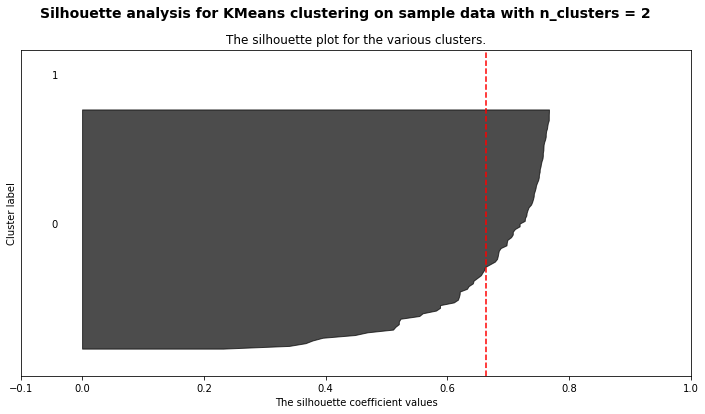

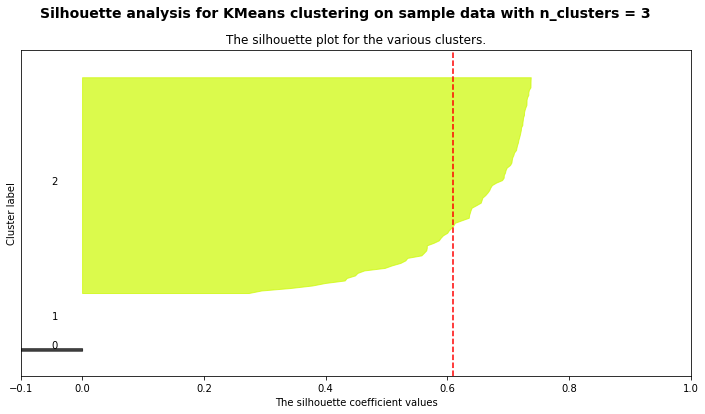

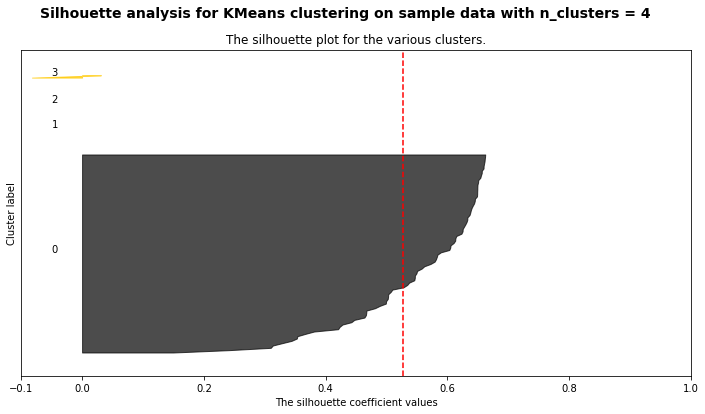

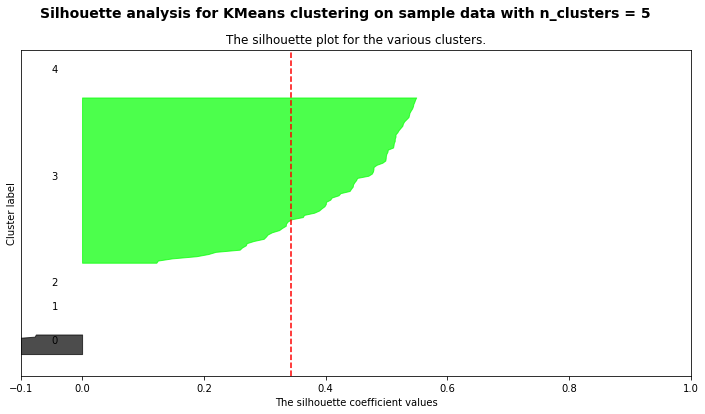

Number of clusters  Average silhouette score  \
0                   2                  0.663346   
1                   3                  0.609616   
2                   4                  0.526914   
3                   5                  0.343690   

                    Size of cluster  \
0                     {0: 89, 1: 1}   
1               {2: 87, 0: 2, 1: 1}   
2         {0: 86, 3: 2, 2: 1, 1: 1}   
3  {3: 77, 0: 10, 4: 1, 2: 1, 1: 1}   

                                  Label assignements  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...  
2  [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, ...

In [8]:
# Convert DataFrame to matrix
beforeMat = beforeForms.as_matrix()
# Standardise data
beforeMat = preprocessing.scale(beforeMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeResults = tryKmeans(beforeMat)
# Format results as a DataFrame
beforeResults = pd.DataFrame(data=beforeResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


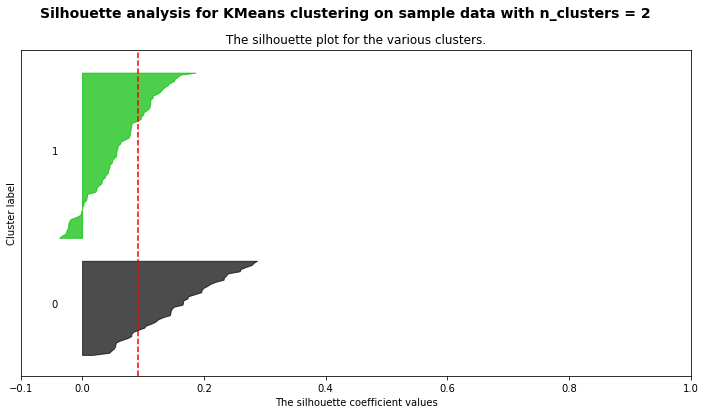

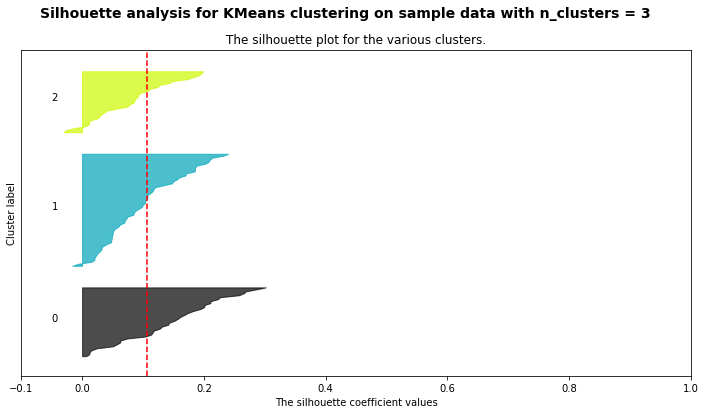

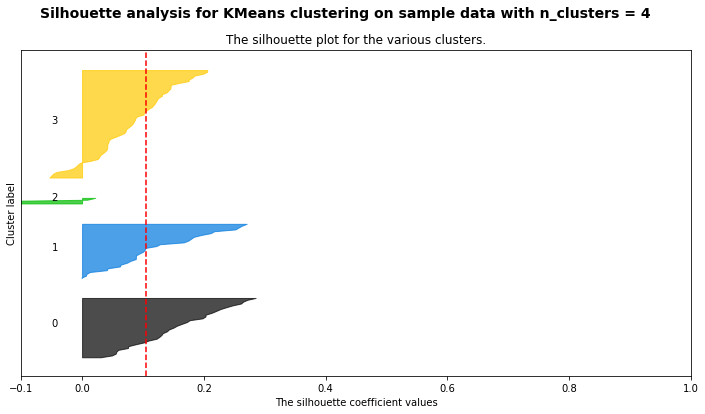

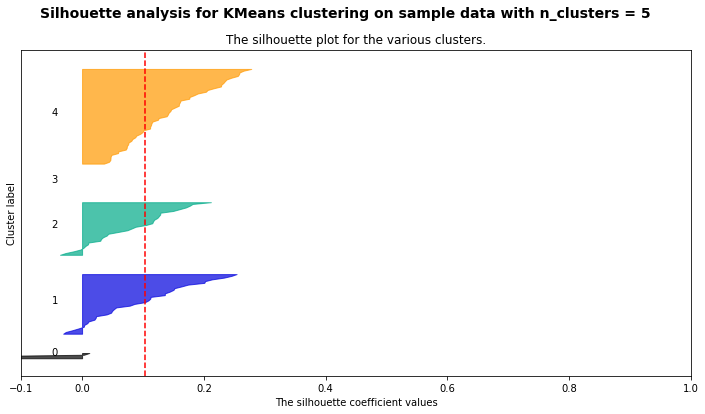

Number of clusters  Average silhouette score  \
0                   2                  0.092341   
1                   3                  0.107395   
2                   4                  0.104313   
3                   5                  0.103712   

                     Size of cluster  \
0                     {1: 80, 0: 46}   
1              {1: 58, 0: 36, 2: 32}   
2        {3: 59, 1: 30, 0: 33, 2: 4}   
3  {4: 55, 1: 35, 2: 31, 0: 4, 3: 1}   

                                  Label assignements  
0  [1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...  
1  [1, 1, 0, 1, 2, 2, 2, 2, 1, 2, 0, 0, 0, 1, 1, ...  
2  [3, 3, 1, 3, 0, 0, 0, 0, 3, 0, 0, 3, 1, 3, 3, ...  
3  [4, 4, 1, 4, 1, 2, 1, 1, 4, 1, 1, 4, 1, 4, 4, ...

In [9]:
# Convert DataFrame to matrix
beforeCorrectedMat = beforeCorrectedForms.as_matrix()
# Standardise data
beforeCorrectedMat = preprocessing.scale(beforeCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeCorrectedResults = tryKmeans(beforeCorrectedMat)
# Format results as a DataFrame
beforeCorrectedResults = pd.DataFrame(data=beforeCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeCorrectedResults

Conclusion: No interesting clustering (29/05/2018)

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

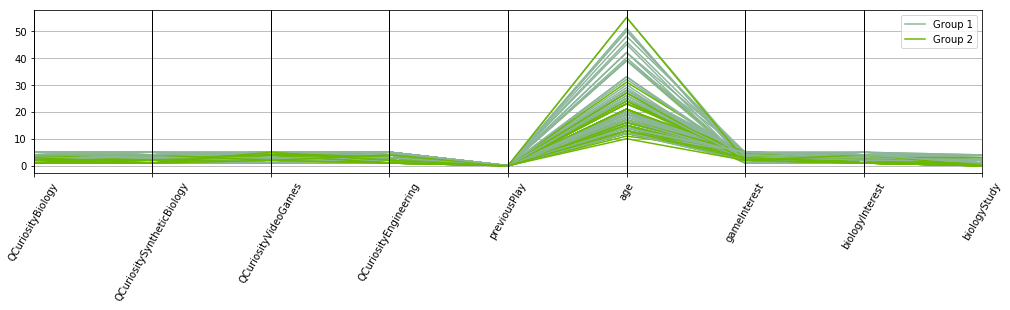

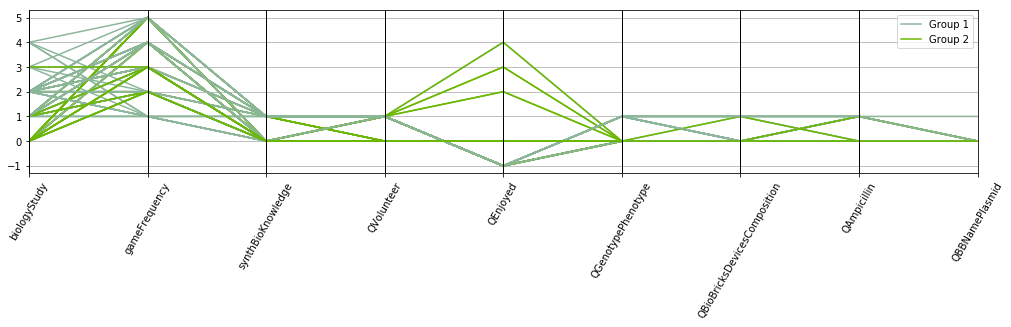

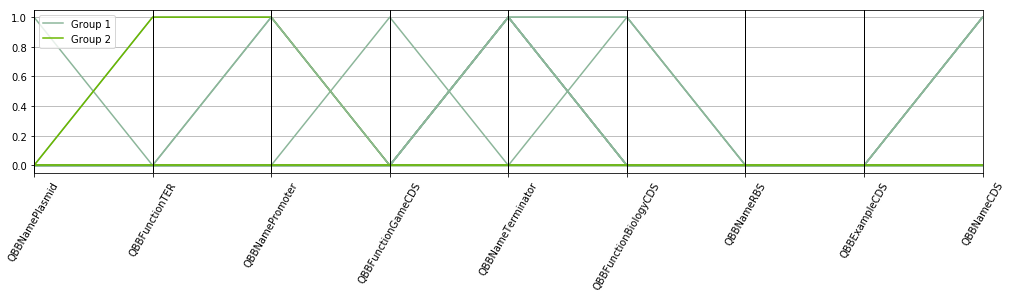

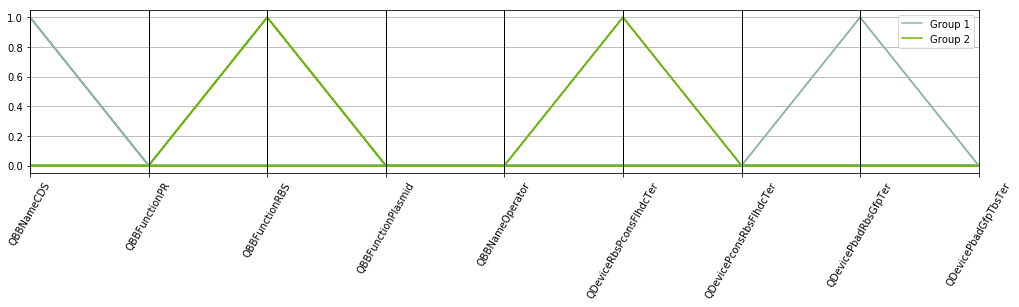

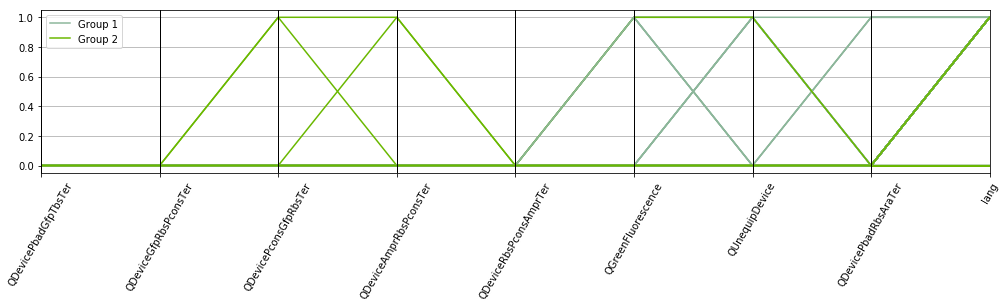

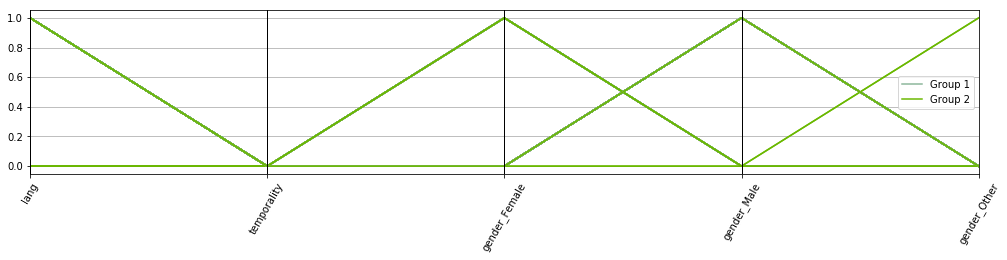

In [10]:
# Display parallel coordinates plot
assignements = detailsKmeans(beforeCorrectedForms, beforeCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

# Can the data be clustered according to the answers given to the after questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


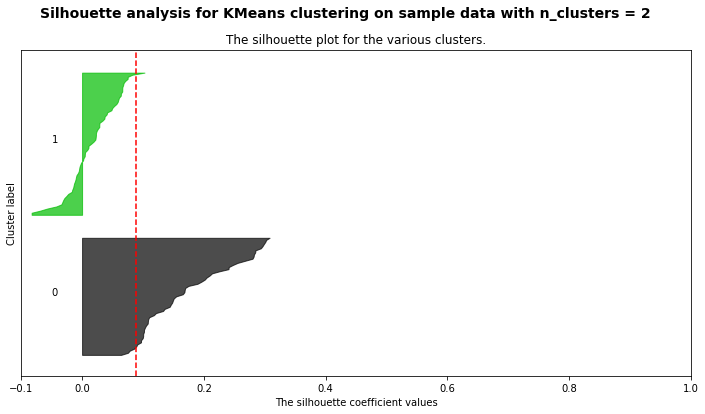

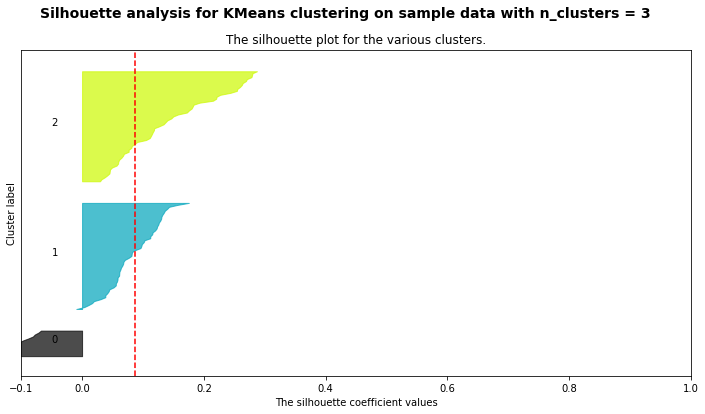

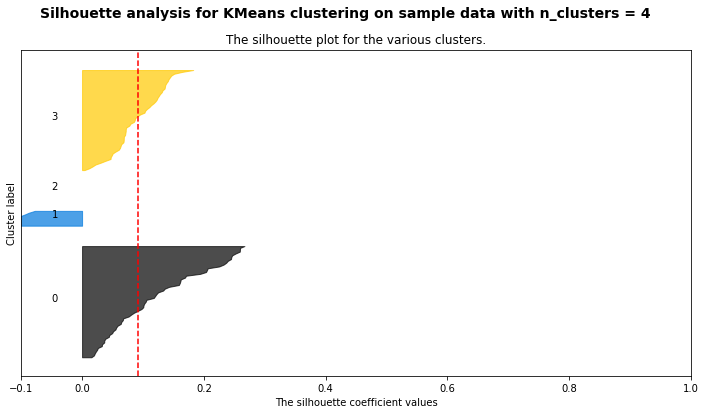

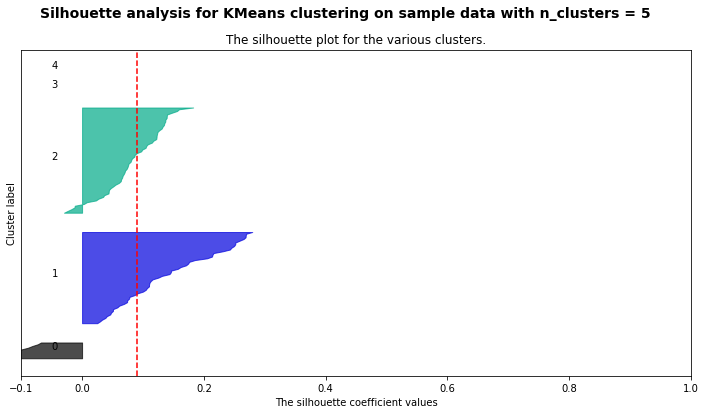

In [11]:
# Convert DataFrame to matrix
afterMat = afterForms.as_matrix()
# Standardise the data
afterMat = preprocessing.scale(afterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterResults = tryKmeans(afterMat)
# Format results as a DataFrame
afterResults = pd.DataFrame(data=afterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


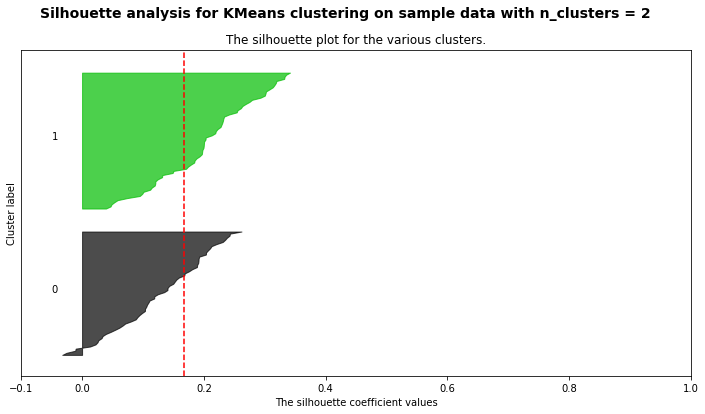

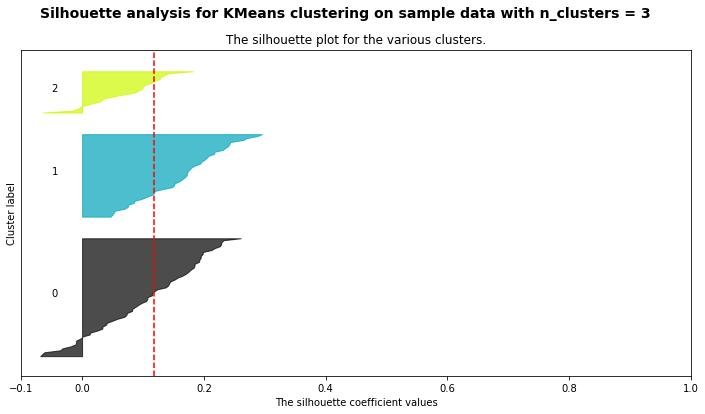

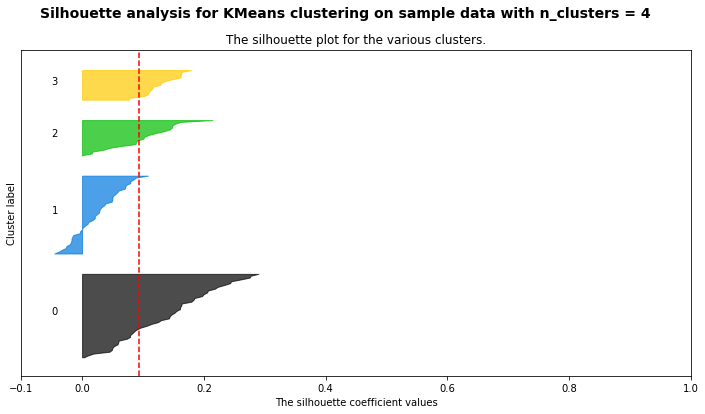

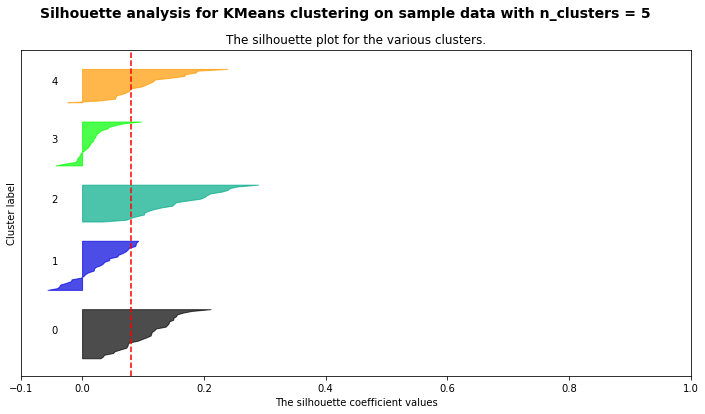

Number of clusters  Average silhouette score  \
0                   2                  0.166766   
1                   3                  0.118358   
2                   4                  0.092741   
3                   5                  0.079615   

                       Size of cluster  \
0                       {0: 60, 1: 66}   
1                {0: 61, 2: 22, 1: 43}   
2         {3: 17, 0: 46, 1: 43, 2: 20}   
3  {0: 29, 1: 29, 4: 20, 3: 26, 2: 22}   

                                  Label assignements  
0  [0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, ...  
1  [0, 2, 0, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 0, ...  
2  [3, 0, 1, 0, 2, 2, 2, 1, 1, 2, 2, 3, 3, 0, 1, ...  
3  [0, 1, 1, 1, 4, 4, 4, 3, 0, 4, 4, 0, 0, 2, 3, ...

In [12]:
# Convert DataFrame to matrix
afterCorrectedMat = afterCorrectedForms.as_matrix()
# Standardise the data
afterCorrectedMat = preprocessing.scale(afterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
afterCorrectedResults = tryKmeans(afterCorrectedMat)
# Format results as a DataFrame
afterCorrectedResults = pd.DataFrame(data=afterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
afterCorrectedResults

Will split columns into 6 groups


FloatProgress(value=0.0, max=6.0)

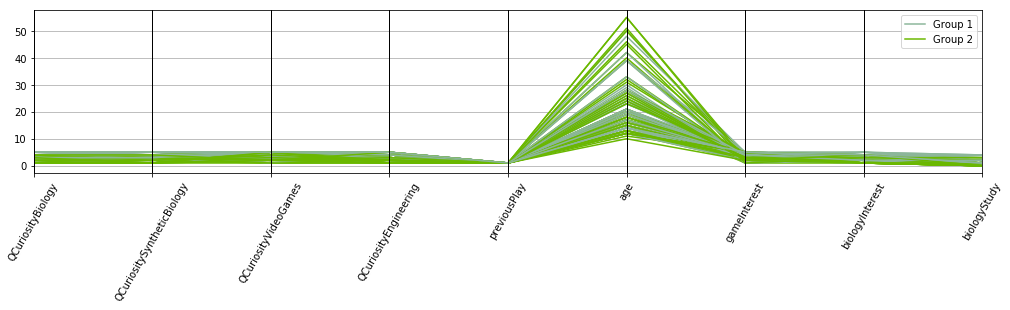

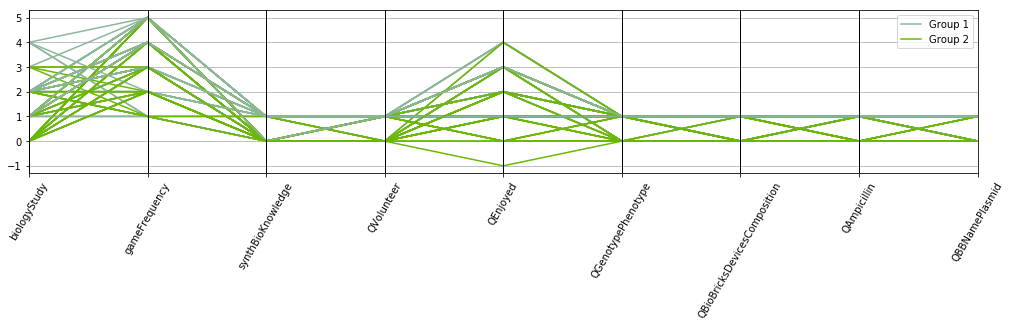

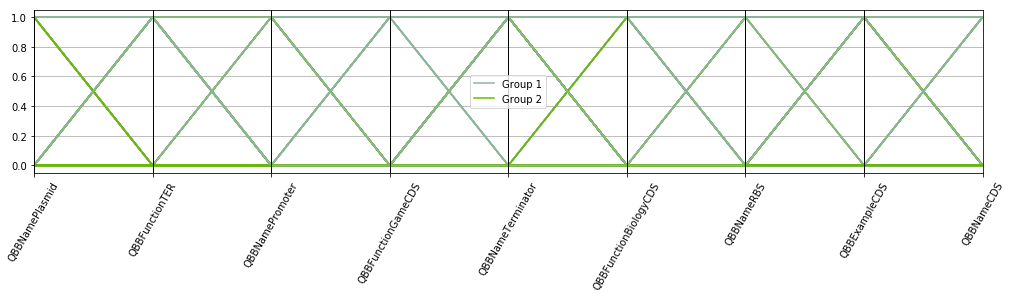

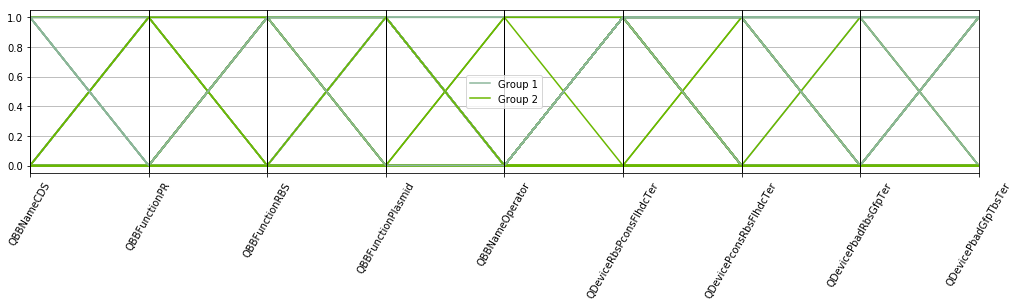

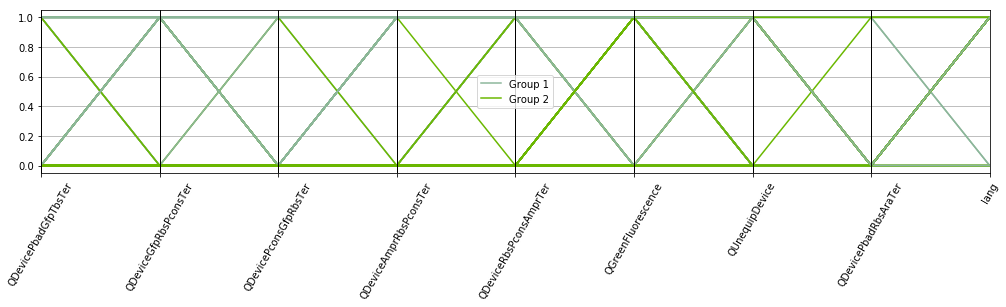

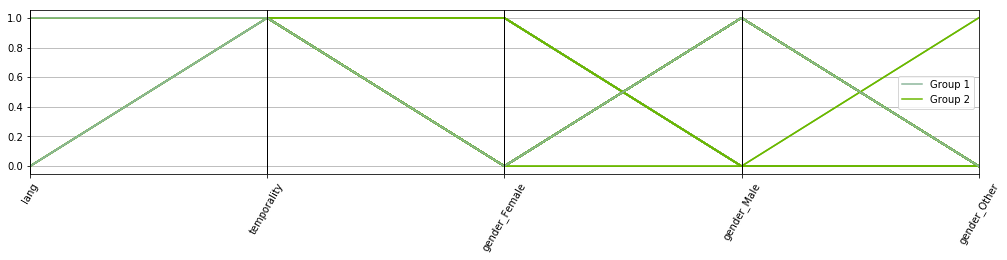

In [13]:
# Display parallel coordinates plot
assignements = detailsKmeans(afterCorrectedForms, afterCorrectedResults, 2, displayParallelCoord=True, clusterLabels=["Group 1", "Group 2"])

In [14]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "allScience")
correctAnswersByCluster

Cluster 0  Cluster 1
QGenotypePhenotype             0.000000     0.3250
QBioBricksDevicesComposition   0.021739     0.1000
QAmpicillin                    0.043478     0.2750
QBBNamePlasmid                 0.000000     0.0125
QBBFunctionTER                 0.021739     0.0125
QBBNamePromoter                0.021739     0.0375
QBBFunctionGameCDS             0.000000     0.0125
QBBNameTerminator              0.000000     0.1250
QBBFunctionBiologyCDS          0.000000     0.0375
QBBNameRBS                     0.000000     0.0000
QBBExampleCDS                  0.000000     0.0000
QBBNameCDS                     0.000000     0.0750
QBBFunctionPR                  0.000000     0.0000
QBBFunctionRBS                 0.065217     0.0500
QBBFunctionPlasmid             0.000000     0.0000
QBBNameOperator                0.000000     0.0000
QDeviceRbsPconsFlhdcTer        0.043478     0.0250
QDevicePconsRbsFlhdcTer        0.000000     0.0000
QDevicePbadRbsGfpTer           0.000000     0.0250
QDevicePbadGfpTbsTer           0.000000     0.0000
QDeviceGfpRbsPconsTer          0.000000     0.0000
QDevicePconsGfpRbsTer          0.043478     0.0000
QDeviceAmprRbsPconsTer         0.043478     0.0000
QDeviceRbsPconsAmprTer         0.000000     0.0000
QGreenFluorescence             0.021739     0.0750
QUnequipDevice                 0.021739     0.0875
QDevicePbadRbsAraTer           0.000000     0.0500

In [15]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=-2.2602530256150217, pvalue=0.028019953409650623)

In [16]:
# Compute frequency of different levels of biology study for each group and each question
biologyStudyPerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "biologyStudy")
biologyStudyPerCluster

Ttest_indResult(statistic=-7.262131765483463, pvalue=3.68804396897294e-11)


Cluster 0  Cluster 1
0   0.543478     0.0875
1   0.369565     0.2875
2   0.065217     0.5250
3   0.021739     0.0500
4   0.000000     0.0500

In [17]:
# Compute frequency of different levels of synthBioKnowledge for each group and each question
synthBioKnowledgePerCluster = freqByCluster(beforeCorrectedForms, beforeCorrectedResults, 2, "synthBioKnowledge")
synthBioKnowledgePerCluster

Ttest_indResult(statistic=-2.9436159604256473, pvalue=0.003873845746092614)


Cluster 0  Cluster 1
0   0.804348       0.55
1   0.195652       0.45

In [18]:
# Compute score and compare clusters
afterCorrectedForms["sum"] = afterCorrectedForms.loc[:,"QGenotypePhenotype":"QDevicePbadRbsAraTer"].sum(axis=1)
scorePerCluster = freqByCluster(afterCorrectedForms, afterCorrectedResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=19.574894123868262, pvalue=9.691818068000671e-40)


Cluster 0  Cluster 1
0    0.000000   0.075758
1    0.000000   0.106061
2    0.000000   0.136364
3    0.000000   0.060606
4    0.000000   0.151515
5    0.000000   0.121212
6    0.000000   0.136364
7    0.000000   0.075758
8    0.000000   0.045455
9    0.050000   0.030303
10   0.016667   0.015152
11   0.033333   0.030303
12   0.100000   0.015152
13   0.116667   0.000000
14   0.100000   0.000000
15   0.050000   0.000000
16   0.083333   0.000000
17   0.066667   0.000000
18   0.133333   0.000000
19   0.116667   0.000000
20   0.033333   0.000000
21   0.050000   0.000000
22   0.016667   0.000000
23   0.033333   0.000000

Conclusion: Two clusters, one with slightly higher level of biology Study and synthetic biology previous knowledge, and much higher scores. See above for details of questions. (29/05/18)

# Can the data be clustered according to the answers given to the questionnaire?

## If scientific questions are coded by answers

### If only before and after questionnaires are used

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


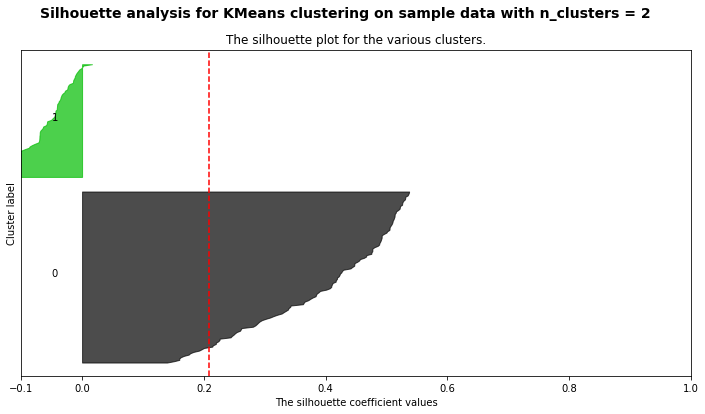

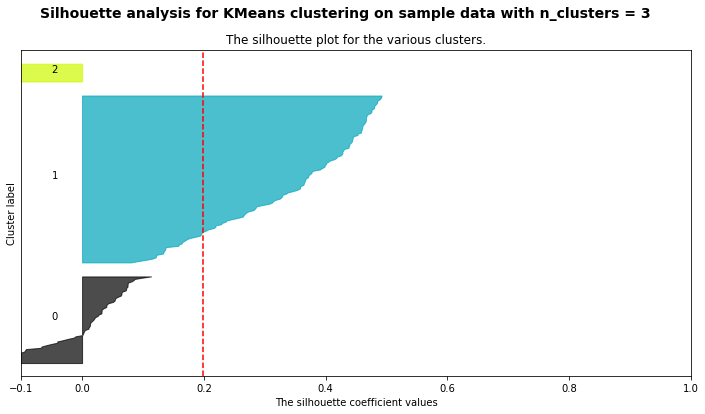

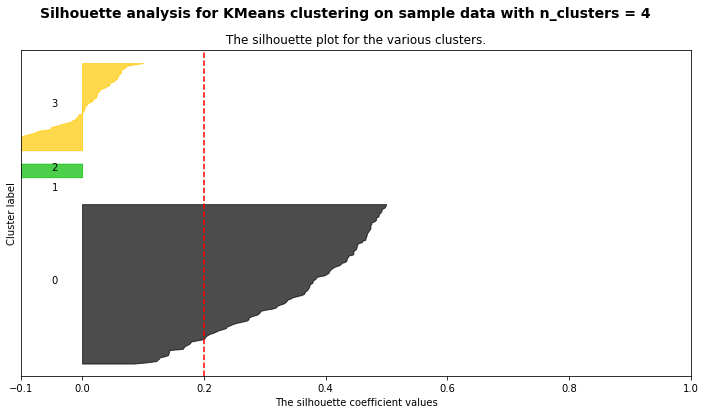

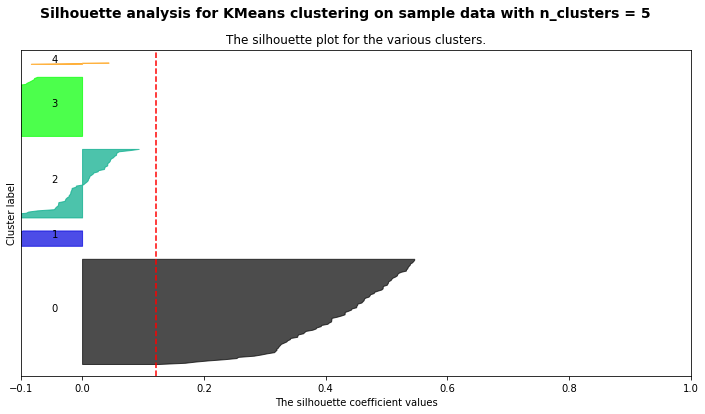

Number of clusters  Average silhouette score  \
0                   2                  0.208847   
1                   3                  0.198945   
2                   4                  0.200502   
3                   5                  0.121786   

                      Size of cluster  \
0                     {0: 130, 1: 86}   
1              {1: 132, 0: 69, 2: 15}   
2        {0: 131, 3: 72, 2: 12, 1: 1}   
3  {0: 90, 2: 59, 3: 51, 1: 14, 4: 2}   

                                  Label assignements  
0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...  
1  [1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...  
2  [0, 3, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, ...  
3  [0, 2, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 0, 2, 2, ...

In [19]:
# Convert DataFrame to matrix
defMat = defForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defMat = preprocessing.scale(defMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defResults = tryKmeans(defMat)
# Format results as a DataFrame
defResults = pd.DataFrame(data=defResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defResults

Conclusion: No interesting clustering (29/05/18)

### If all questionnaires are used

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


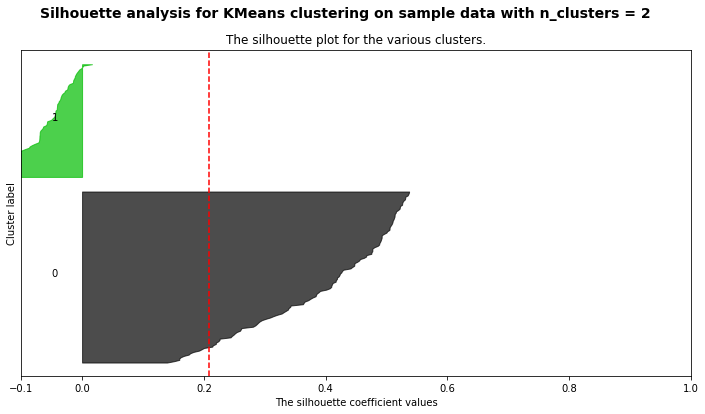

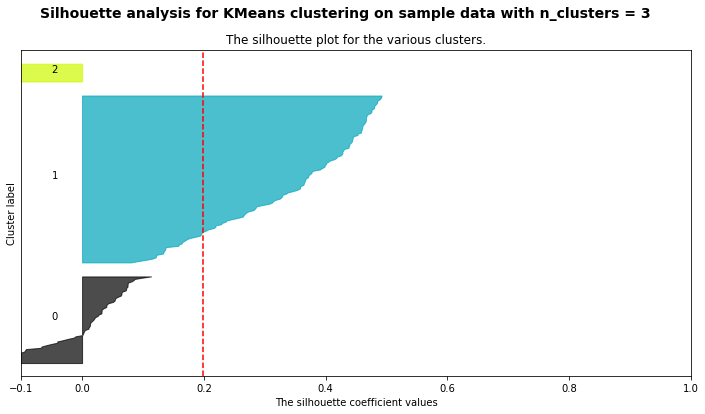

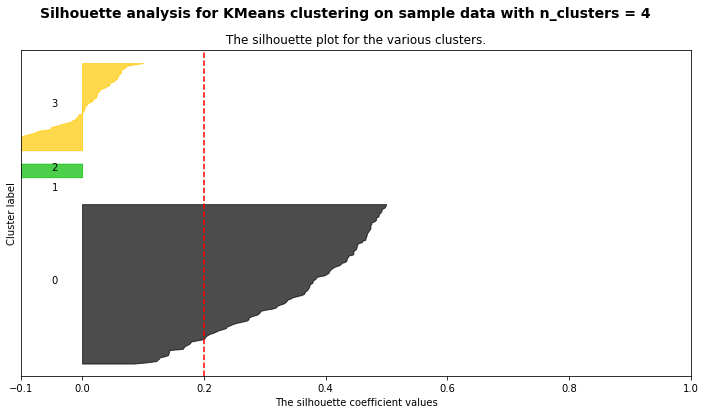

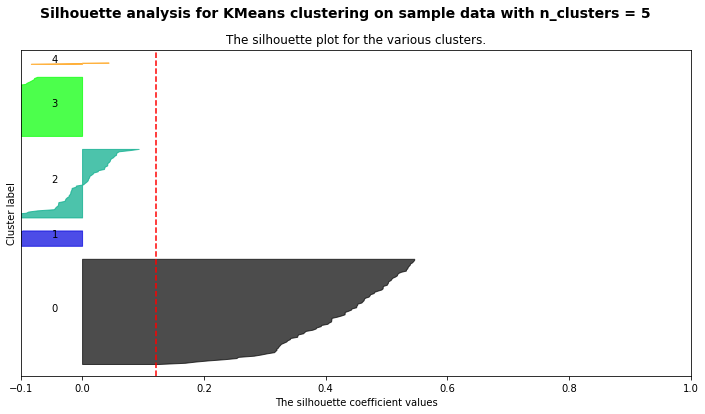

Number of clusters  Average silhouette score  \
0                   2                  0.208847   
1                   3                  0.198945   
2                   4                  0.200502   
3                   5                  0.121786   

                      Size of cluster  \
0                     {0: 130, 1: 86}   
1              {1: 132, 0: 69, 2: 15}   
2        {0: 131, 3: 72, 2: 12, 1: 1}   
3  {0: 90, 2: 59, 3: 51, 1: 14, 4: 2}   

                                  Label assignements  
0  [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...  
1  [1, 0, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...  
2  [0, 3, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, ...  
3  [0, 2, 3, 1, 0, 3, 3, 3, 3, 0, 3, 3, 0, 2, 2, ...

In [20]:
# Convert DataFrame to matrix
allMat = allForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allMat = preprocessing.scale(allMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allResults = tryKmeans(allMat)
# Format results as a DataFrame
allResults = pd.DataFrame(data=allResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allResults

Conclusion: No interesting clustering (16/01/2018)

In [21]:
assignements = detailsKmeans(allForms, allResults, 2)
assignements = pd.concat([assignements, allForms["temporality"]], axis=1, join='inner')
defConfusionMat = confusion_matrix(list(assignements["temporality"]), list(assignements["Index of cluster"]))
defConfusionMat = pd.DataFrame(data = defConfusionMat, columns=["Predicted before", "Predicted after"], index = ["Actual after", "Actual before"])
defConfusionMat

Predicted before  Predicted after
Actual after                 88                2
Actual before                42               84

## If scientific questions are coded by correctedness

### If only before and after questionnaires are used

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


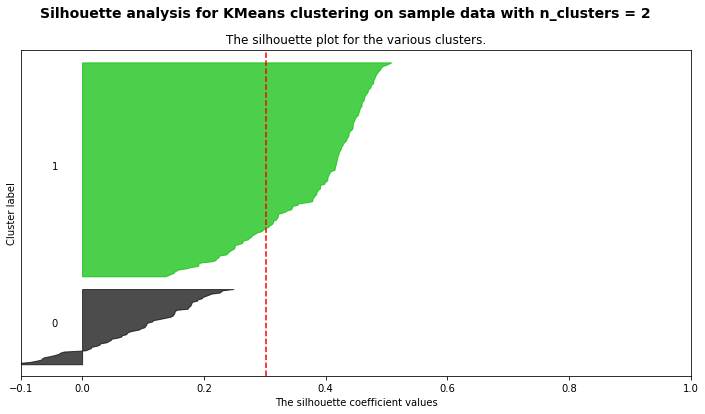

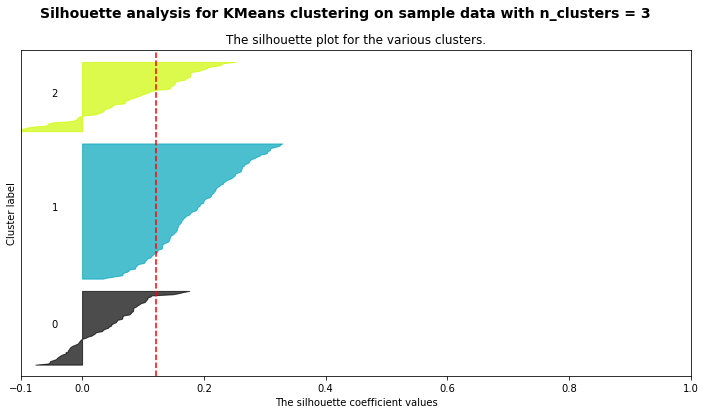

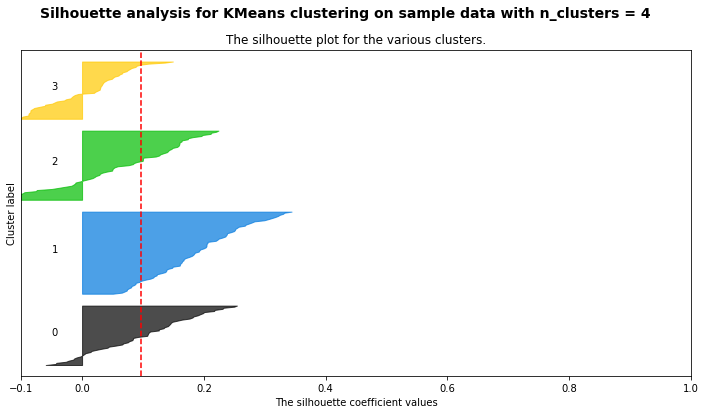

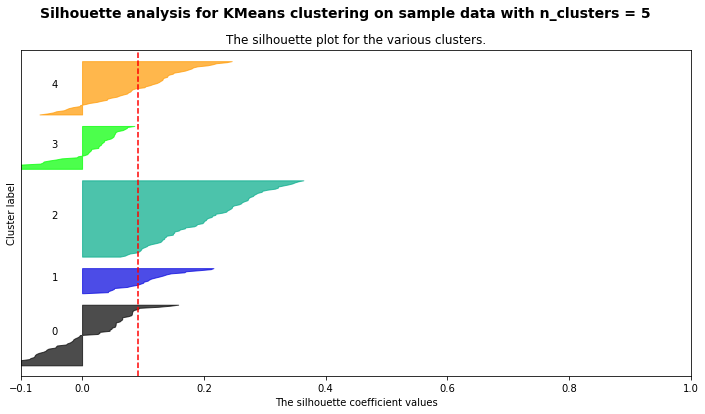

Number of clusters  Average silhouette score  \
0                   2                  0.301800   
1                   3                  0.121749   
2                   4                  0.096899   
3                   5                  0.091740   

                       Size of cluster  \
0                      {1: 186, 0: 66}   
1               {1: 122, 2: 63, 0: 67}   
2         {1: 77, 2: 65, 0: 56, 3: 54}   
3  {2: 74, 1: 25, 4: 52, 3: 42, 0: 59}   

                                  Label assignements  
0  [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...  
1  [1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, ...  
2  [1, 2, 1, 0, 1, 1, 2, 1, 3, 2, 3, 3, 3, 3, 3, ...  
3  [2, 1, 2, 4, 2, 2, 3, 2, 0, 3, 0, 0, 0, 0, 0, ...

In [22]:
# Convert DataFrame to matrix
defCorrectedMat = defCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
defCorrectedMat = preprocessing.scale(defCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
defCorrectedResults = tryKmeans(defCorrectedMat)
# Format results as a DataFrame
defCorrectedResults = pd.DataFrame(data=defCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
defCorrectedResults

Conclusion: No interesting clustering (29/05/18)

### If all questionnaires are used

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


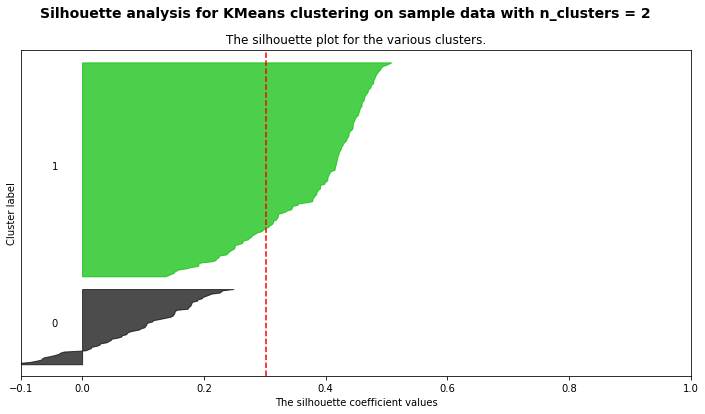

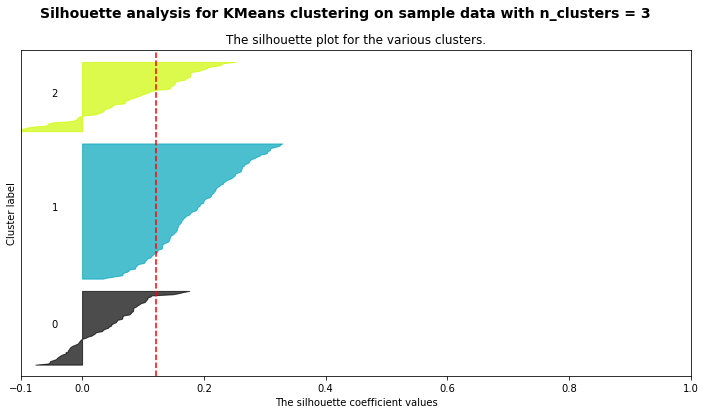

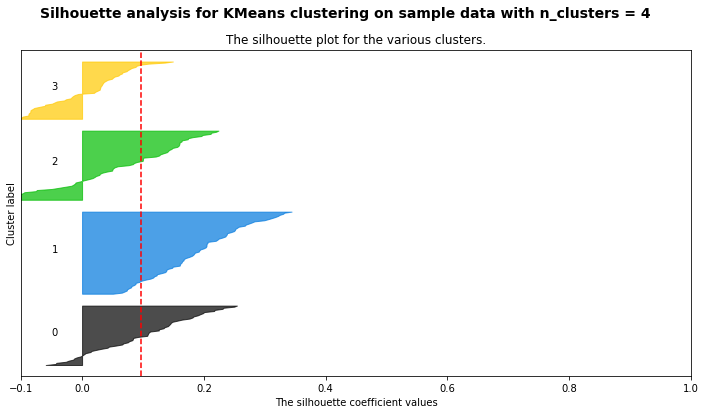

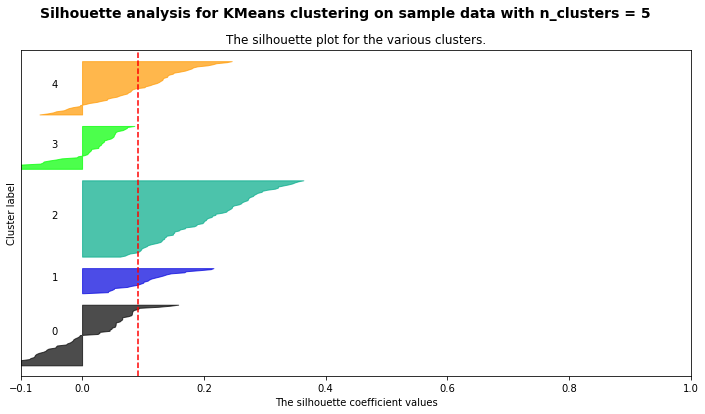

Number of clusters  Average silhouette score  \
0                   2                  0.301800   
1                   3                  0.121749   
2                   4                  0.096899   
3                   5                  0.091740   

                       Size of cluster  \
0                      {1: 186, 0: 66}   
1               {1: 122, 2: 63, 0: 67}   
2         {1: 77, 2: 65, 0: 56, 3: 54}   
3  {2: 74, 1: 25, 4: 52, 3: 42, 0: 59}   

                                  Label assignements  
0  [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, ...  
1  [1, 2, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 0, ...  
2  [1, 2, 1, 0, 1, 1, 2, 1, 3, 2, 3, 3, 3, 3, 3, ...  
3  [2, 1, 2, 4, 2, 2, 3, 2, 0, 3, 0, 0, 0, 0, 0, ...

In [23]:
# Convert DataFrame to matrix
allCorrectedMat = allCorrectedForms.drop("temporality", axis=1).as_matrix()
# Standardise data
allCorrectedMat = preprocessing.scale(allCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allCorrectedResults = tryKmeans(allCorrectedMat)
# Format results as a DataFrame
allCorrectedResults = pd.DataFrame(data=allCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allCorrectedResults

Conclusion: No interesting clustering (29/05/18)

# Can the data be clustered according to the answers given to both the before and the after questionnaire?

# TODO! Rethink meaning of this section with new experiment

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


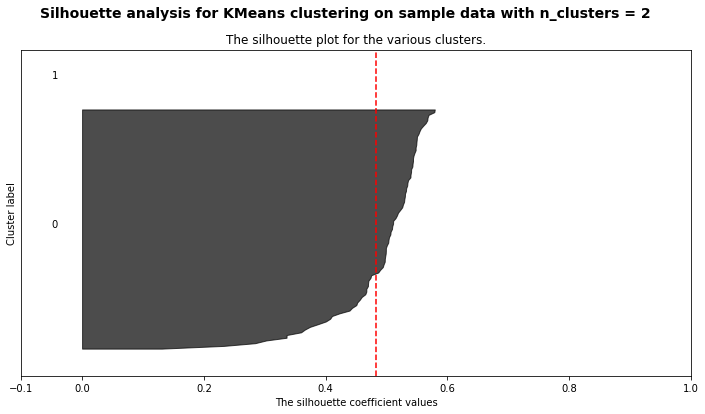

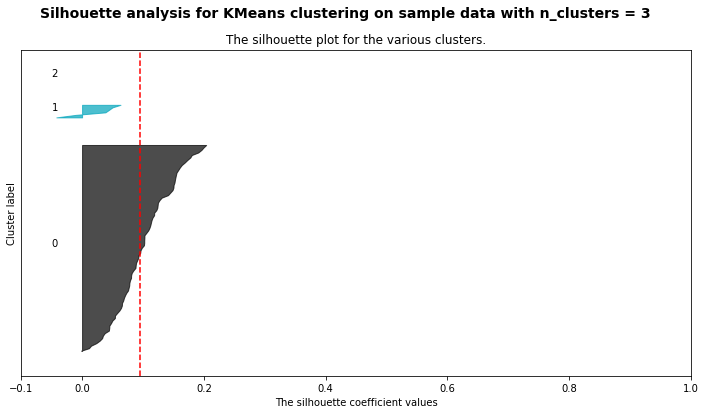

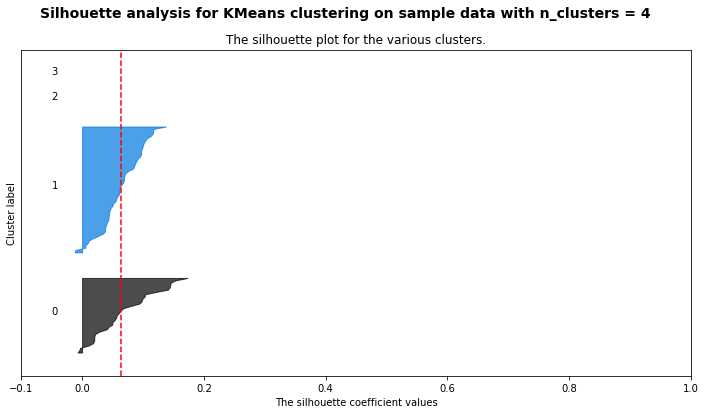

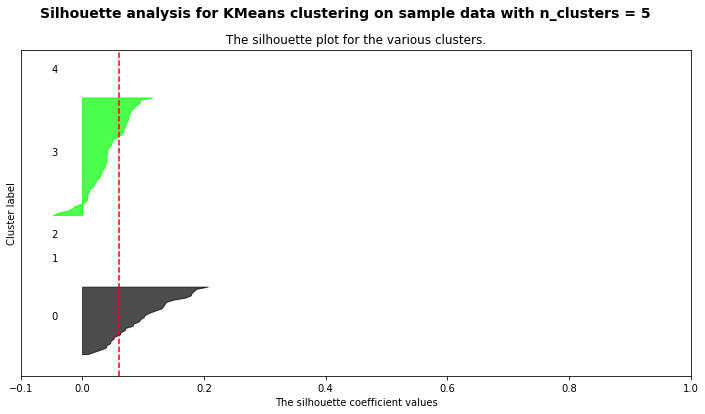

Number of clusters  Average silhouette score  \
0                   2                  0.483472   
1                   3                  0.095039   
2                   4                  0.063908   
3                   5                  0.060490   

                    Size of cluster  \
0                     {0: 89, 1: 1}   
1               {0: 83, 1: 6, 2: 1}   
2        {1: 55, 2: 1, 0: 33, 3: 1}   
3  {3: 55, 2: 1, 0: 32, 4: 1, 1: 1}   

                                  Label assignements  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [1, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, ...  
3  [3, 2, 3, 0, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, ...

In [24]:
# Convert DataFrame to matrix
beforeAndAfterMat = beforeAndAfterForms.as_matrix()
# Standardise the data
beforeAndAfterMat = preprocessing.scale(beforeAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterResults = tryKmeans(beforeAndAfterMat)
# Format results as a DataFrame
beforeAndAfterResults = pd.DataFrame(data=beforeAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterResults

Conclusion: No interesting clustering (30/11/2017)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


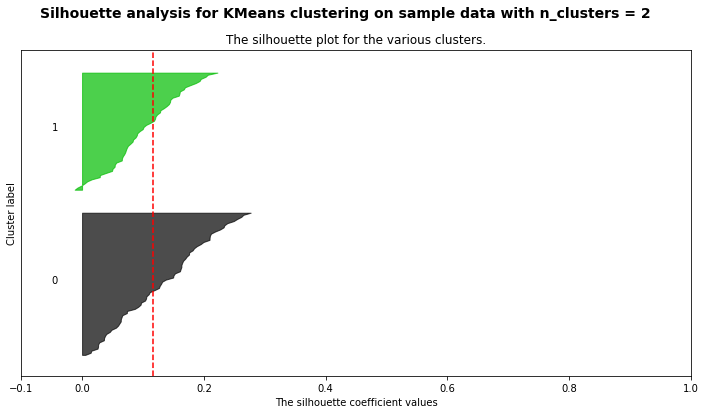

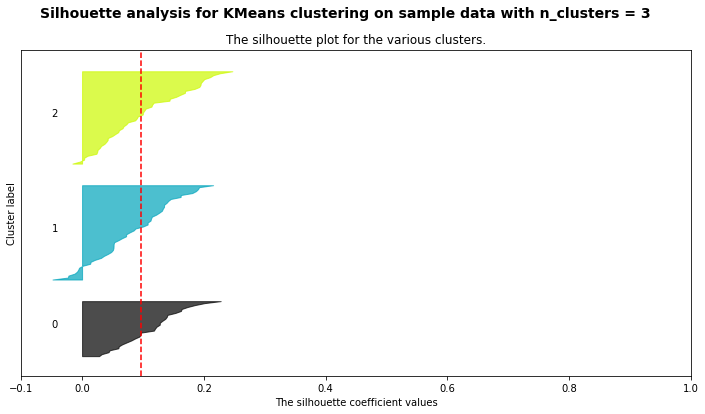

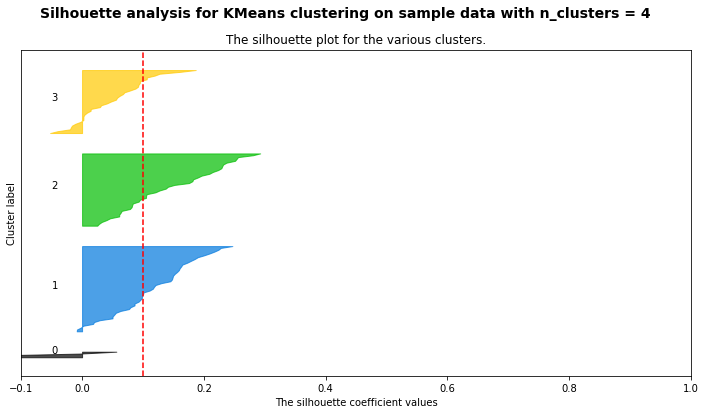

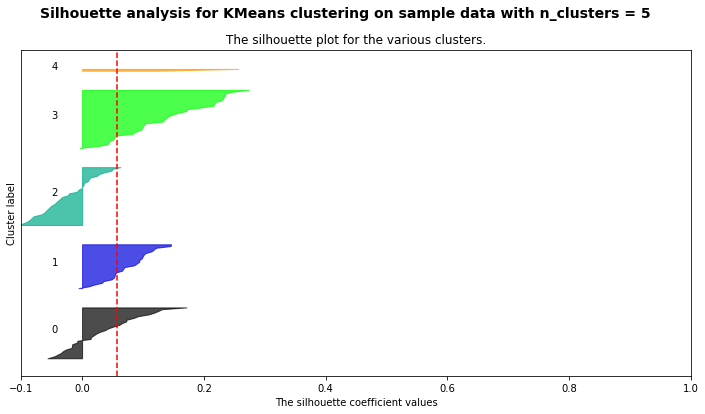

Number of clusters  Average silhouette score  \
0                   2                  0.117144   
1                   3                  0.096288   
2                   4                  0.100090   
3                   5                  0.057463   

                      Size of cluster  \
0                      {1: 57, 0: 69}   
1               {1: 49, 2: 48, 0: 29}   
2         {1: 47, 2: 40, 3: 35, 0: 4}   
3  {2: 34, 3: 34, 1: 26, 0: 30, 4: 2}   

                                  Label assignements  
0  [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, ...  
1  [1, 2, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2, ...  
2  [1, 2, 2, 1, 3, 3, 3, 3, 1, 3, 1, 1, 2, 1, 2, ...  
3  [2, 3, 3, 1, 0, 0, 1, 0, 2, 0, 1, 2, 3, 1, 3, ...

In [25]:
# Convert DataFrame to matrix
beforeAndAfterCorrectedMat = beforeAndAfterCorrectedForms.as_matrix()
# Standardise the data
beforeAndAfterCorrectedMat = preprocessing.scale(beforeAndAfterCorrectedMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
beforeAndAfterCorrectedResults = tryKmeans(beforeAndAfterCorrectedMat)
# Format results as a DataFrame
beforeAndAfterCorrectedResults = pd.DataFrame(data=beforeAndAfterCorrectedResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
beforeAndAfterCorrectedResults

Conclusion: The data could be clustered in two groups (29/05/18)

Will split columns into 12 groups


FloatProgress(value=0.0, max=12.0)

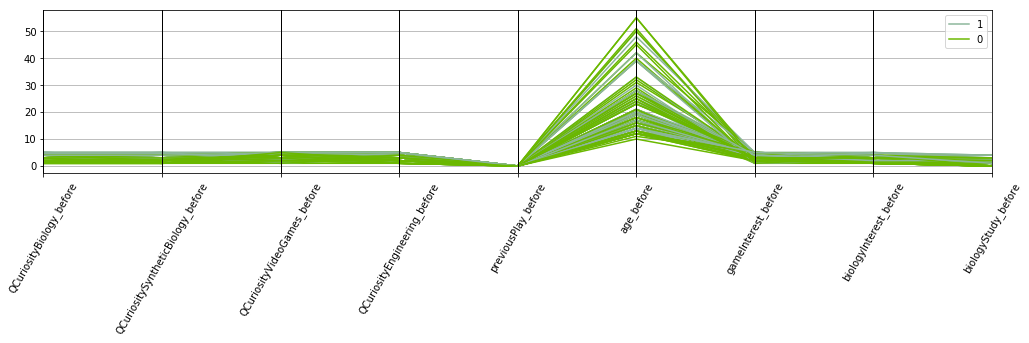

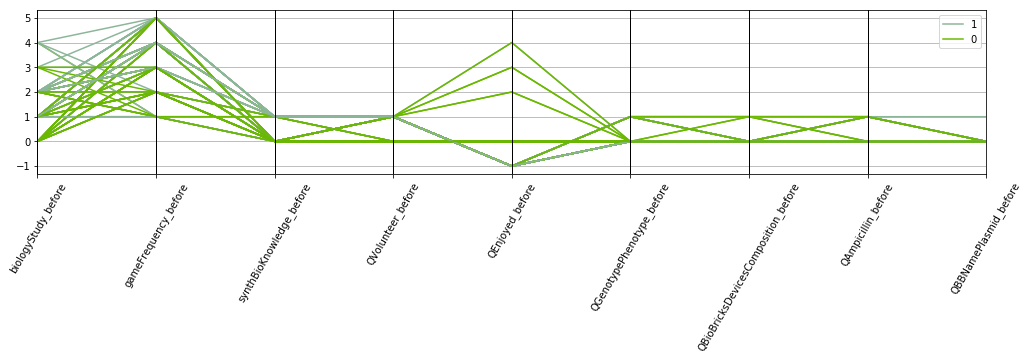

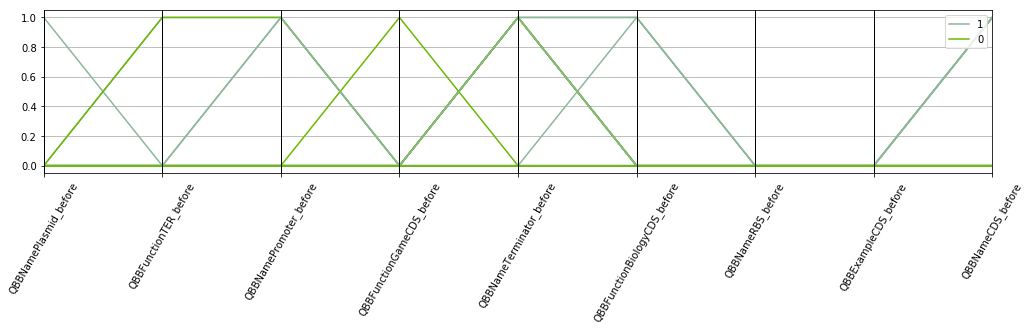

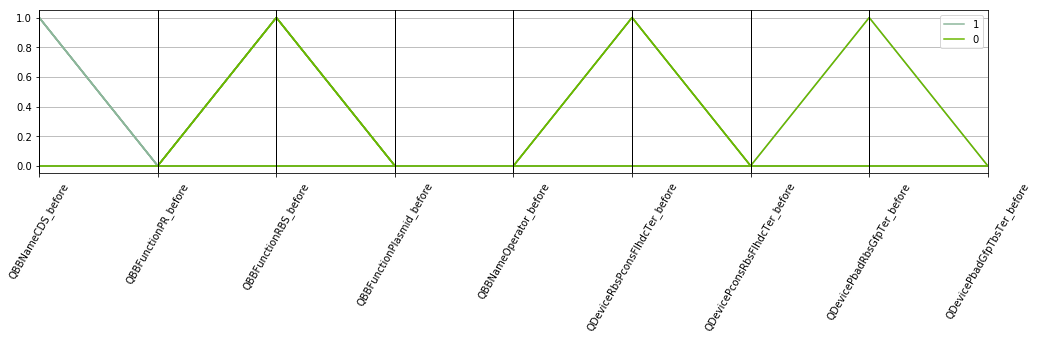

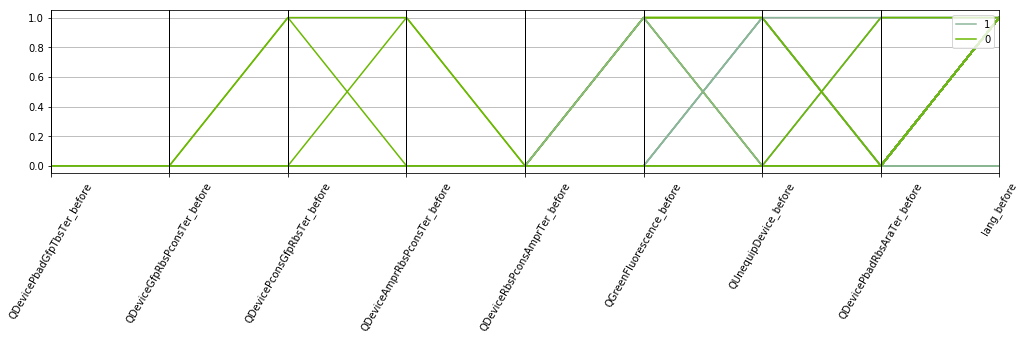

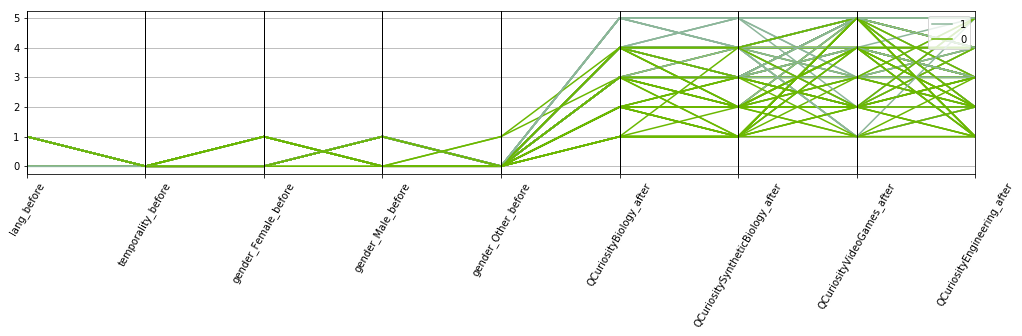

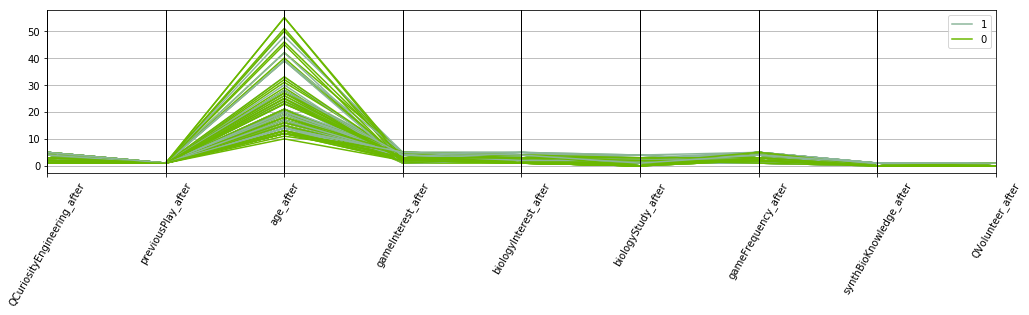

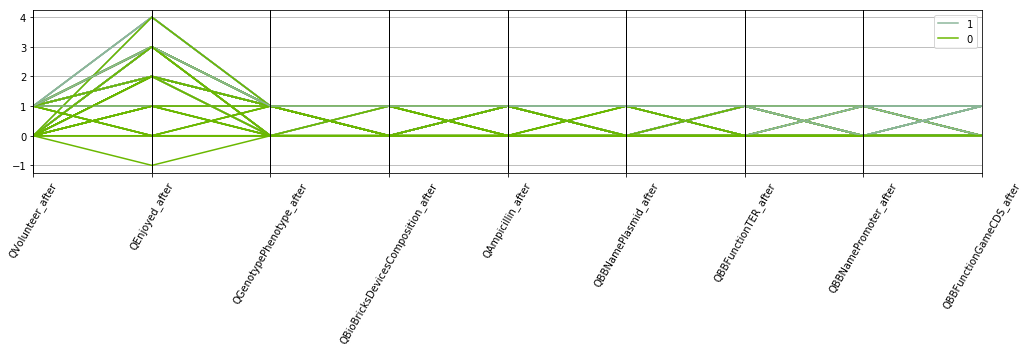

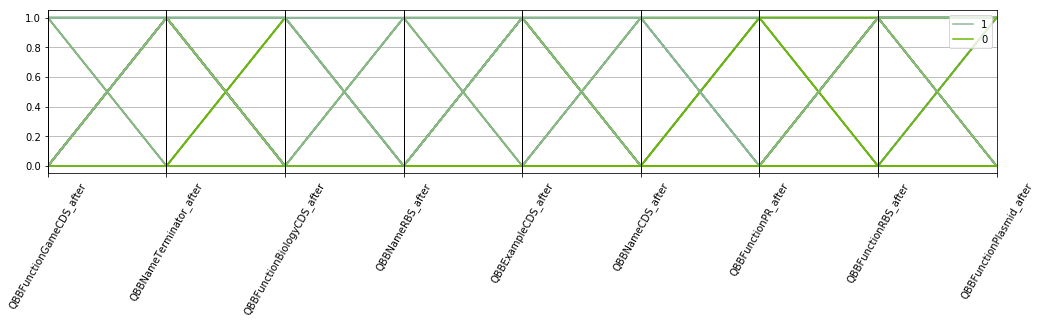

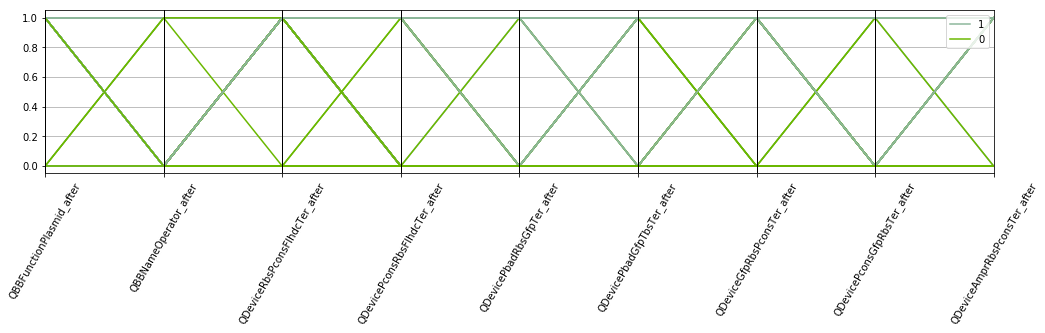

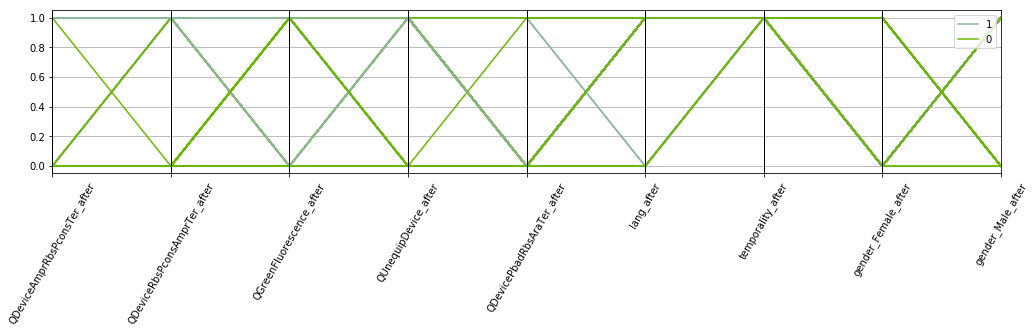

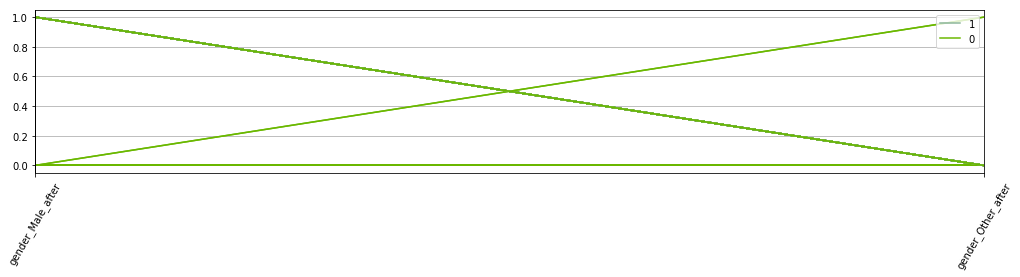

In [26]:
assignements = detailsKmeans(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, displayParallelCoord=True)

In [27]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "previousPlay_before")
correctAnswersByCluster

Ttest_indResult(statistic=nan, pvalue=nan)


C:\Users\Mikael\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Mikael\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Mikael\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Cluster 0  Cluster 1
0          1          1

In [28]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_before")
correctAnswersByCluster

Ttest_indResult(statistic=-4.777200431421066, pvalue=4.927980057616823e-06)


Cluster 0  Cluster 1
1   0.275362   0.017544
2   0.202899   0.105263
3   0.362319   0.596491
4   0.159420   0.192982
5   0.000000   0.087719

In [29]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyStudy_before")
correctAnswersByCluster

Ttest_indResult(statistic=-3.4106579952160256, pvalue=0.0008752600423827932)


Cluster 0  Cluster 1
0   0.362319   0.122807
1   0.333333   0.298246
2   0.246377   0.491228
3   0.043478   0.035088
4   0.014493   0.052632

In [30]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(beforeAndAfterCorrectedForms, beforeAndAfterCorrectedResults, 2, "biologyInterest_after")
correctAnswersByCluster

Ttest_indResult(statistic=-4.777200431421066, pvalue=4.927980057616823e-06)


Cluster 0  Cluster 1
1   0.275362   0.017544
2   0.202899   0.105263
3   0.362319   0.596491
4   0.159420   0.192982
5   0.000000   0.087719

TODO Raphael: Look in details at scientific questions

# Can the data be clustered according to the RedMetrics values?

## All sessions

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


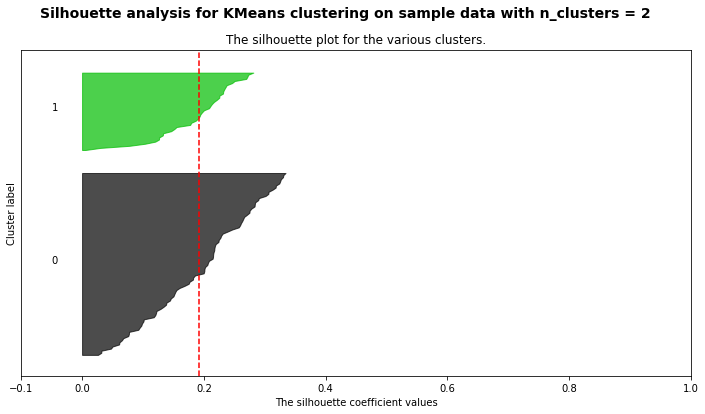

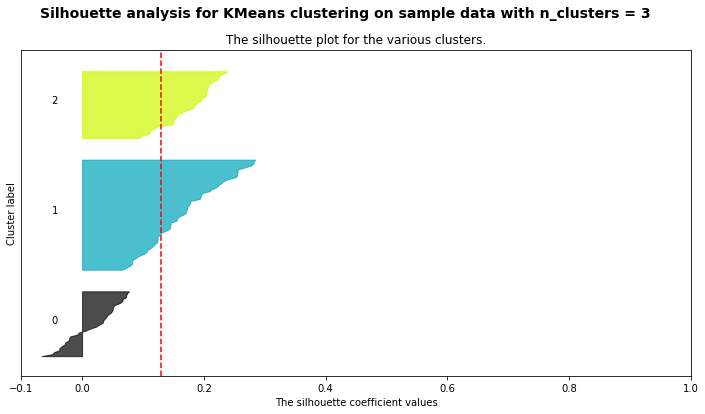

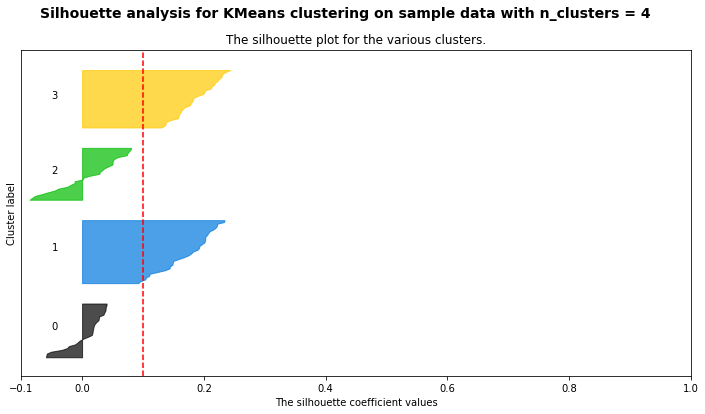

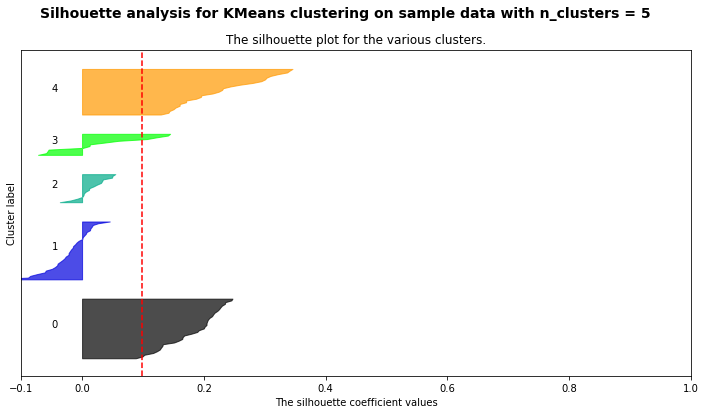

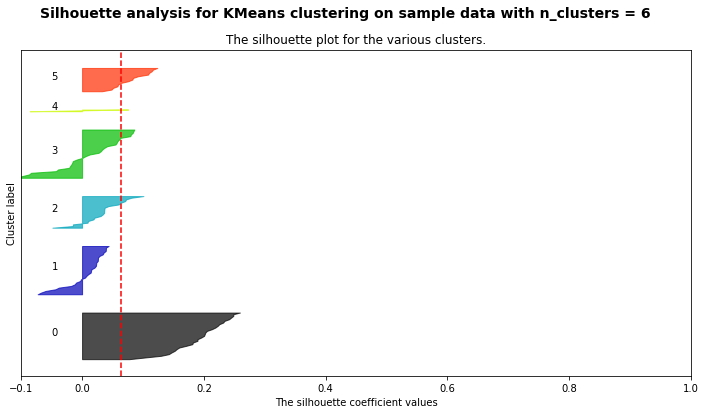

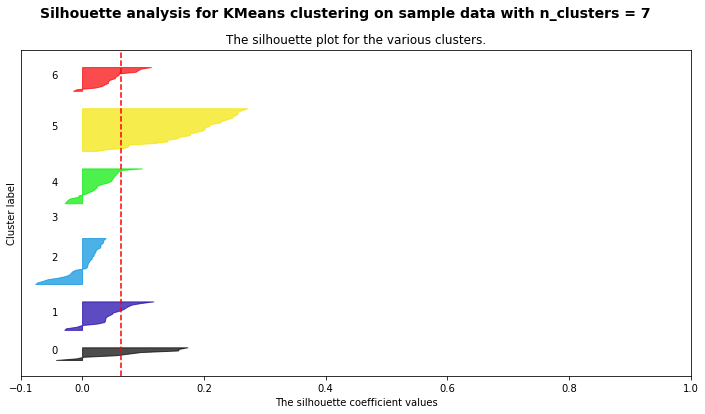

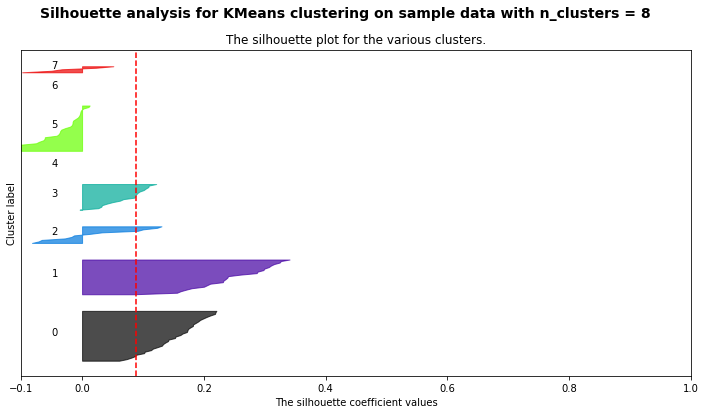

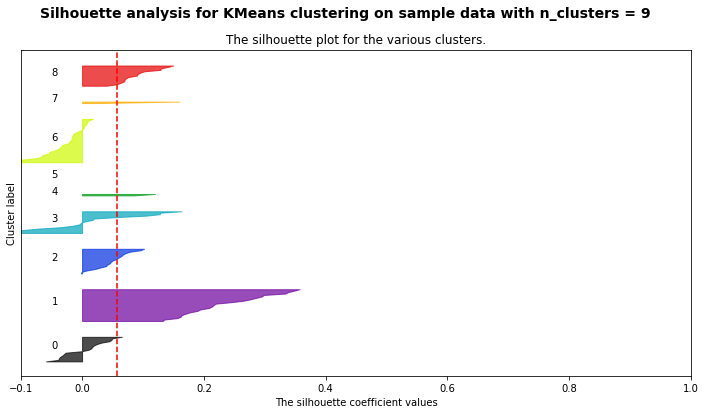

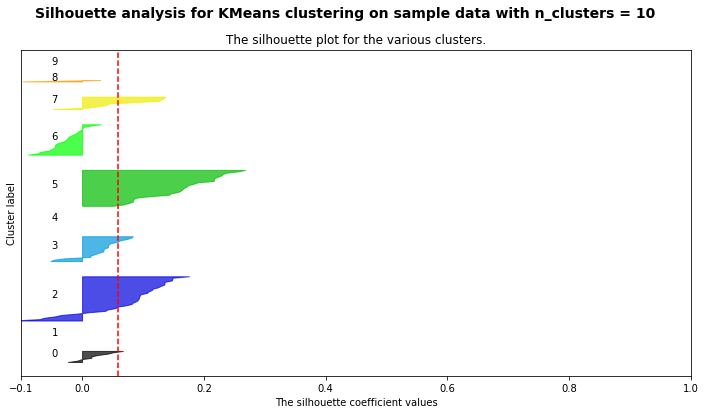

Number of clusters  Average silhouette score  \
0                   2                  0.192337   
1                   3                  0.130165   
2                   4                  0.099273   
3                   5                  0.098520   
4                   6                  0.063230   
5                   7                  0.063291   
6                   8                  0.089134   
7                   9                  0.057879   
8                  10                  0.059841   

                                     Size of cluster  \
0                                     {1: 38, 0: 88}   
1                              {2: 35, 1: 57, 0: 34}   
2                       {1: 35, 3: 32, 0: 30, 2: 29}   
3                {0: 35, 4: 27, 1: 34, 3: 13, 2: 17}   
4          {5: 15, 0: 29, 1: 30, 2: 20, 3: 30, 4: 2}   
5    {1: 19, 5: 28, 2: 30, 6: 16, 0: 9, 4: 23, 3: 1}   
6  {0: 34, 1: 24, 5: 31, 2: 12, 3: 18, 4: 1, 7: 5...   
7  {0: 18, 1: 23, 6: 31, 8: 15, 3: 16, 4: 2, 2: 1...   
8  {2: 33, 5: 27, 6: 23, 0: 9, 7: 10, 3: 19, 8: 2...   

                                  Label assignements  
0  [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...  
1  [2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, ...  
2  [1, 3, 0, 1, 1, 0, 3, 0, 1, 3, 1, 3, 2, 3, 2, ...  
3  [0, 4, 1, 0, 0, 1, 3, 1, 0, 4, 0, 4, 3, 4, 3, ...  
4  [5, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 0, 3, 0, 3, ...  
5  [1, 5, 2, 6, 6, 2, 0, 2, 6, 5, 1, 5, 0, 5, 0, ...  
6  [0, 1, 5, 0, 0, 5, 2, 5, 0, 1, 0, 1, 2, 1, 2, ...  
7  [0, 1, 6, 8, 8, 6, 3, 6, 8, 3, 4, 1, 3, 1, 3, ...  
8  [2, 5, 6, 2, 2, 6, 0, 0, 2, 0, 2, 0, 7, 0, 7, ...

In [31]:
# Convert DataFrame to matrix
allDataMat = allData.iloc[:,:-1].as_matrix()
# Standardise the data
allDataMat = preprocessing.scale(allDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
allDataResults = tryKmeans(allDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
allDataResults = pd.DataFrame(data=allDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
allDataResults

Conclusion: Could be clustered in two groups (29/05/18)

Let's look at the parallel coordinates plot for 2 clusters

Will split columns into 23 groups


FloatProgress(value=0.0, max=23.0)

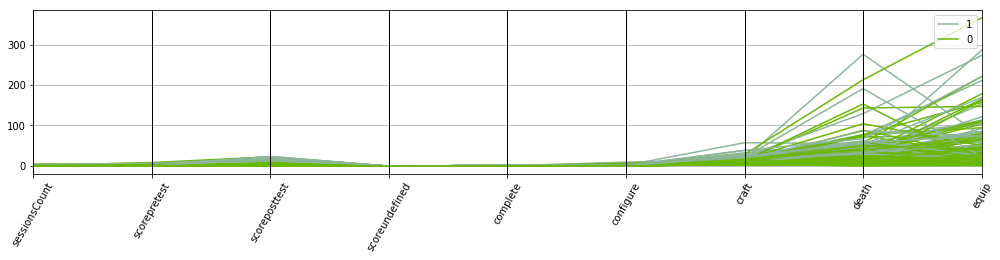

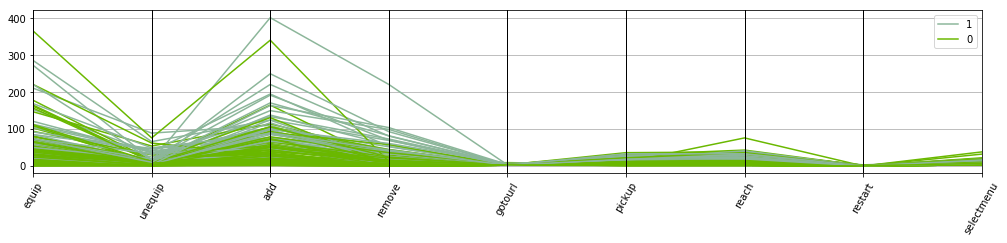

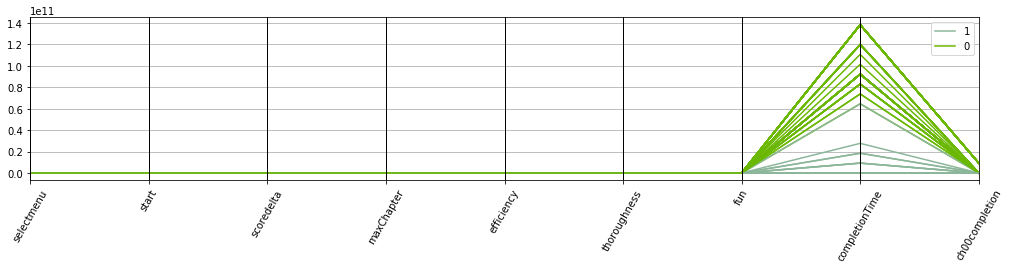

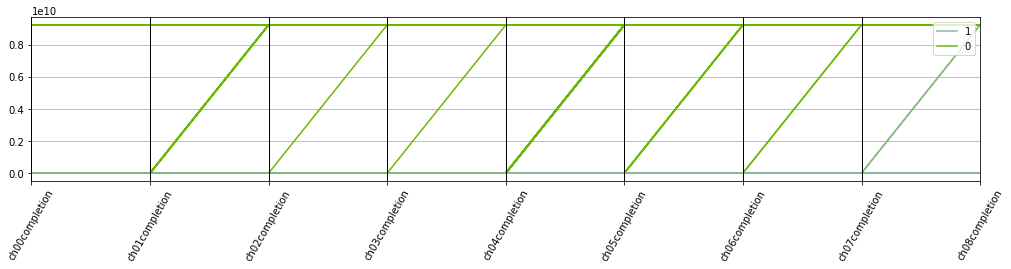

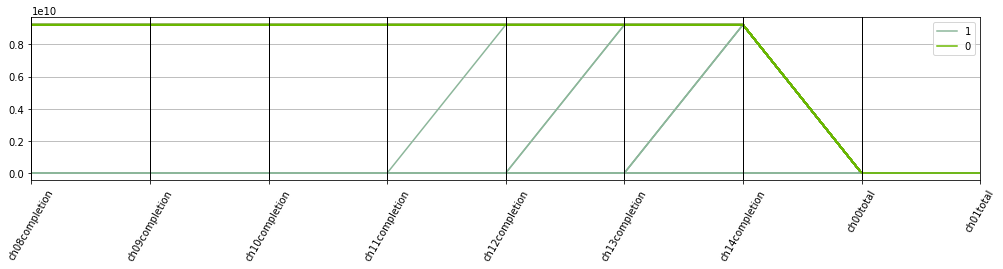

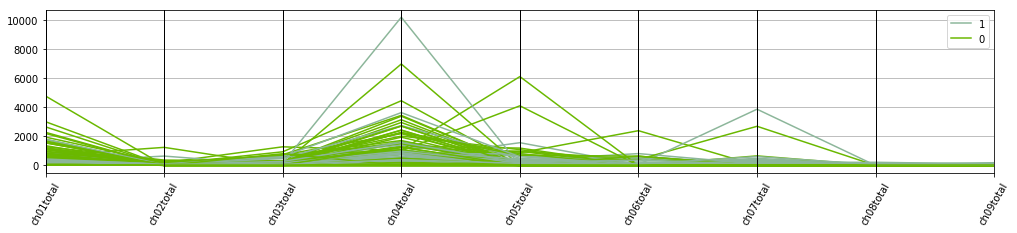

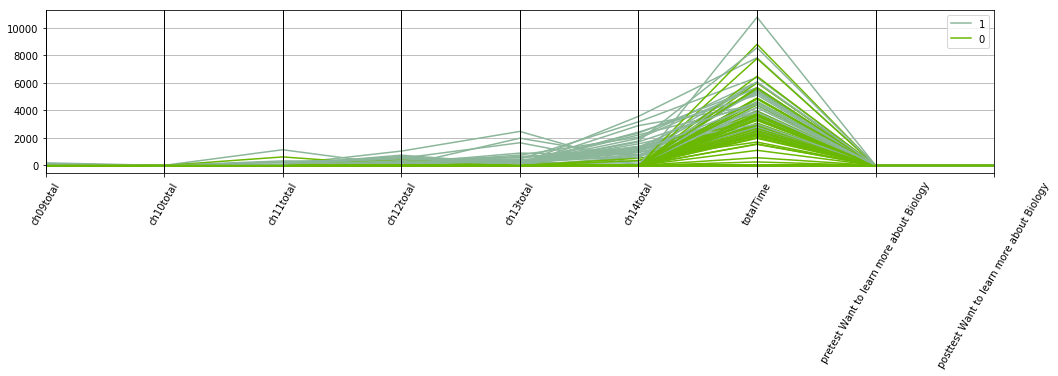

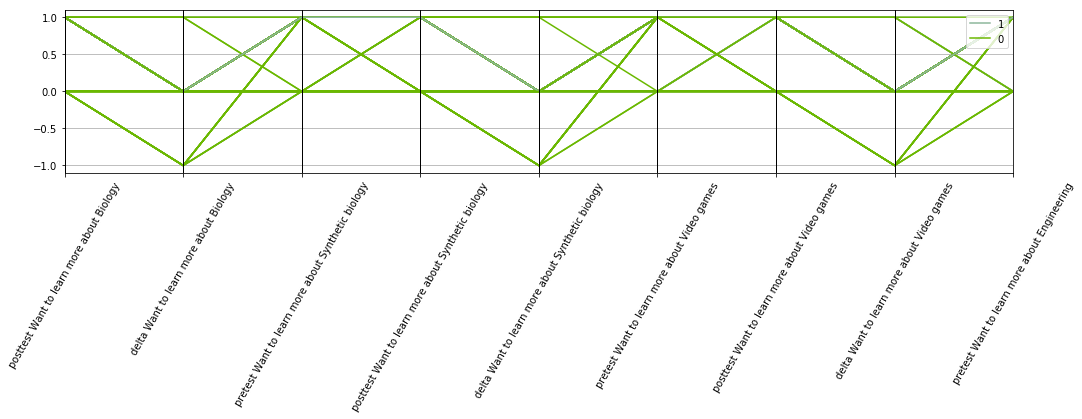

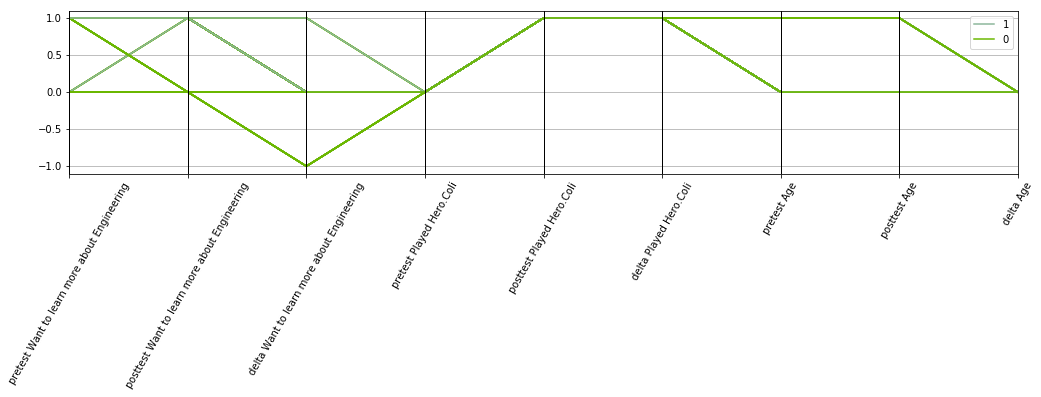

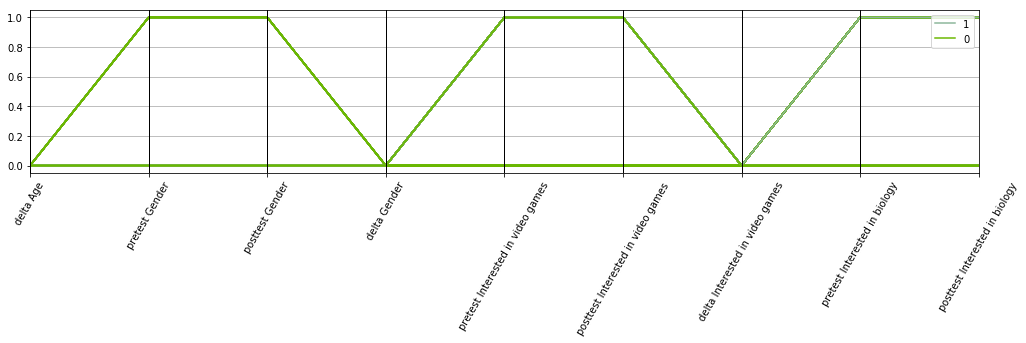

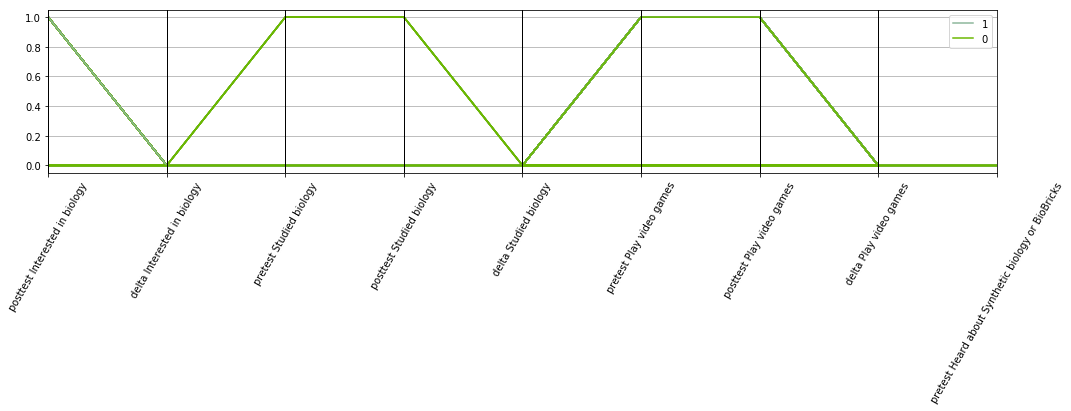

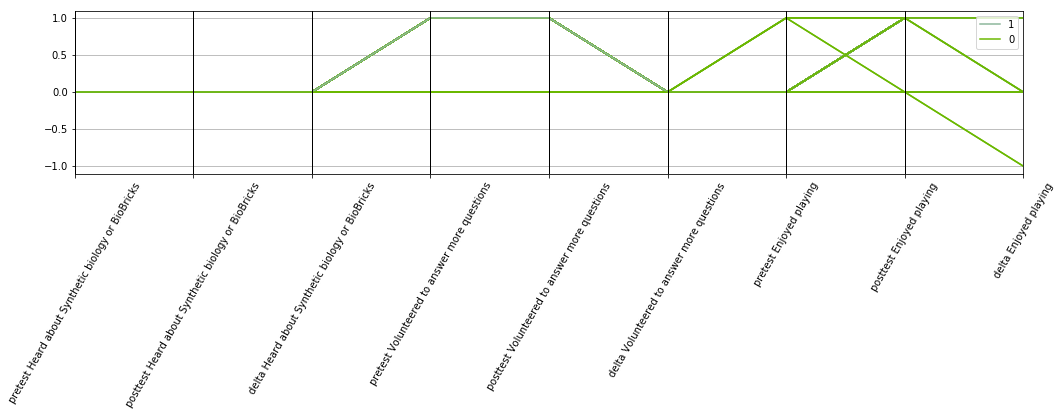

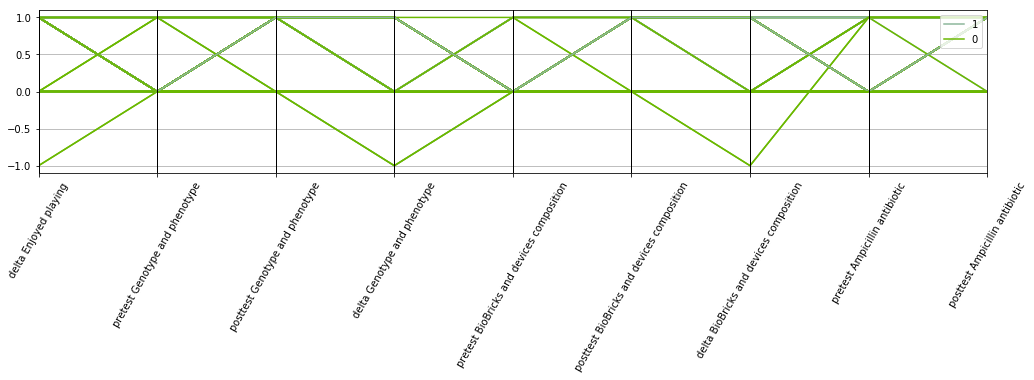

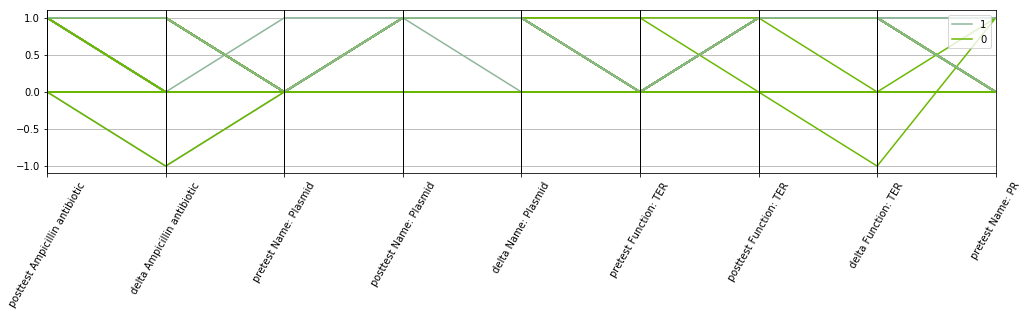

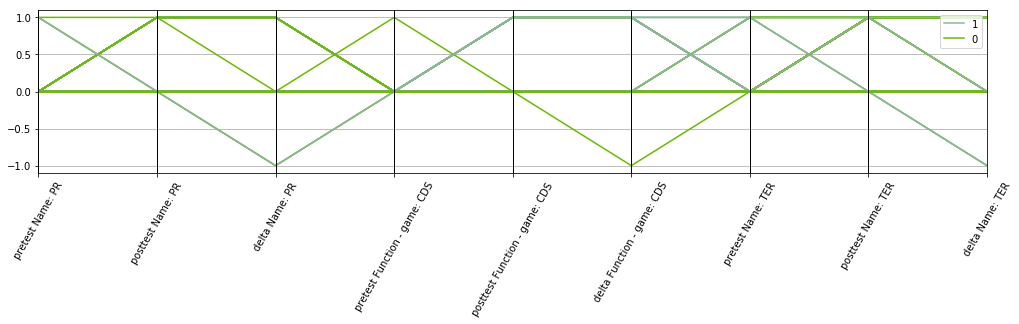

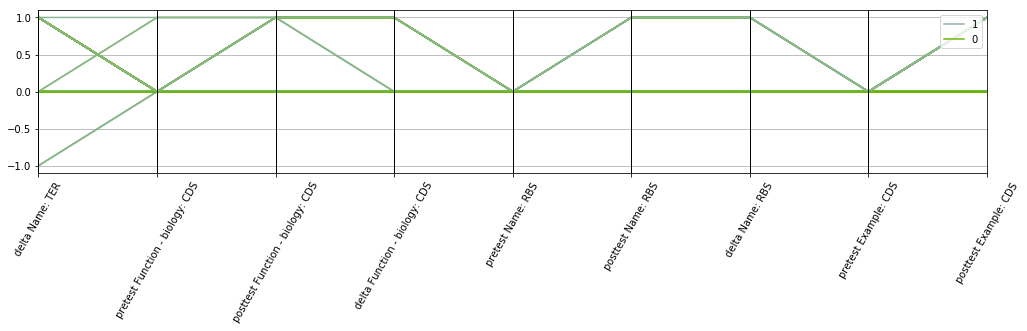

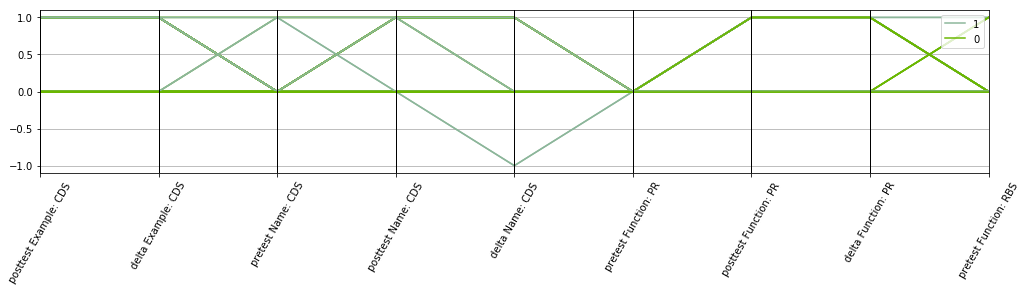

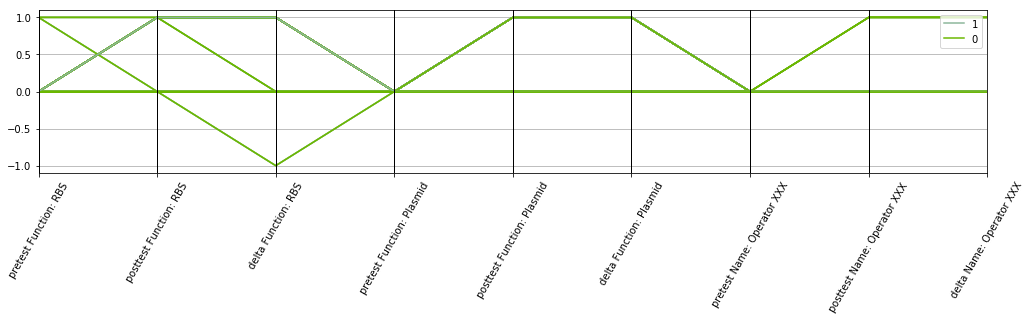

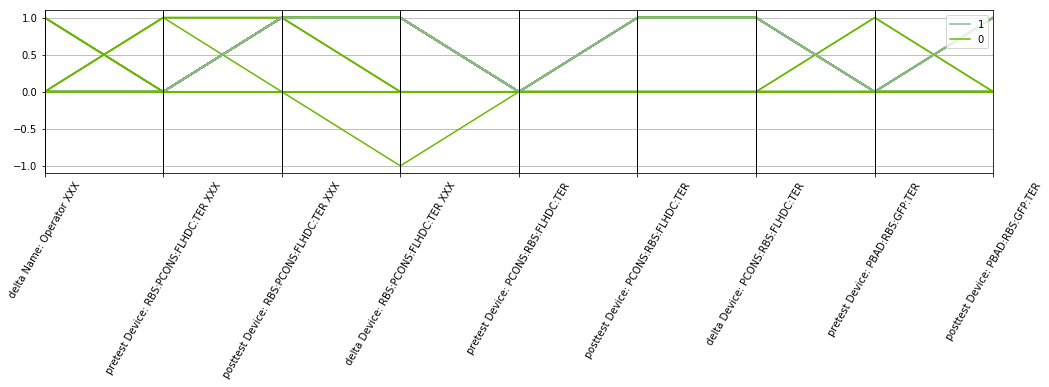

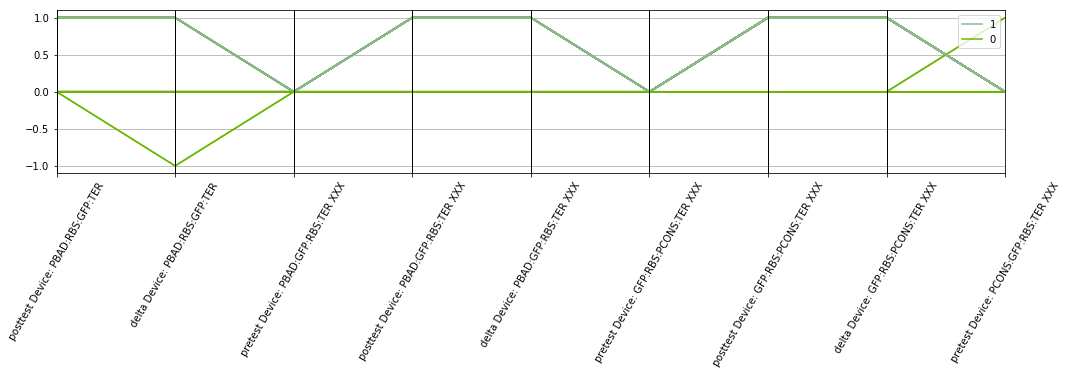

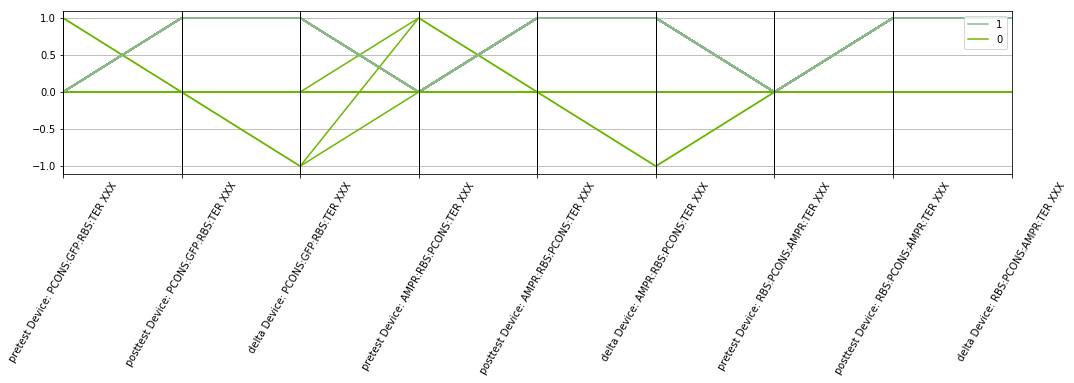

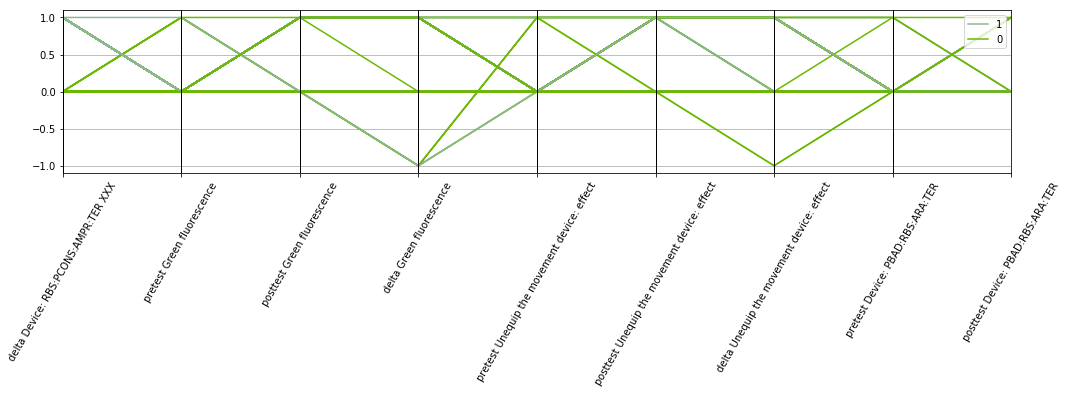

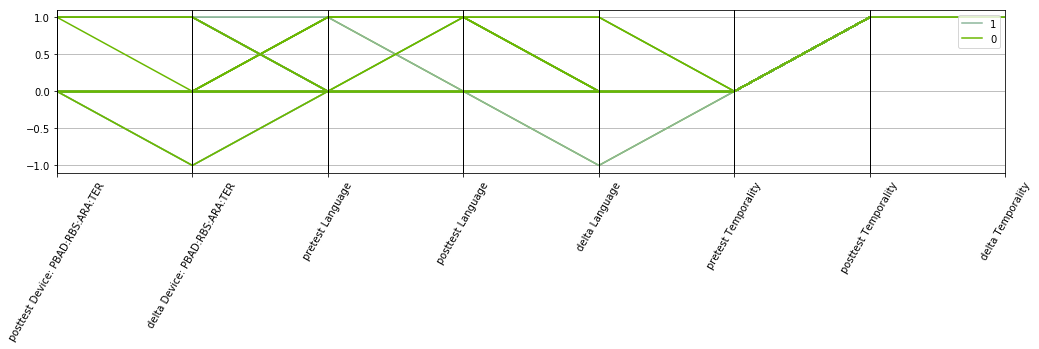

In [32]:
assignements = detailsKmeans(allData, allDataResults, 2, displayParallelCoord=True)

TODO Raphaeal : Check in details, Maybe check sub-divisions of clusters?

## Only sessions where the player has answered the questionnaire before and after playing

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


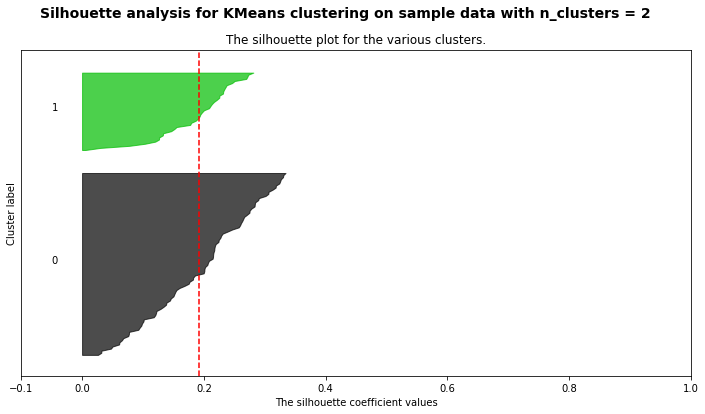

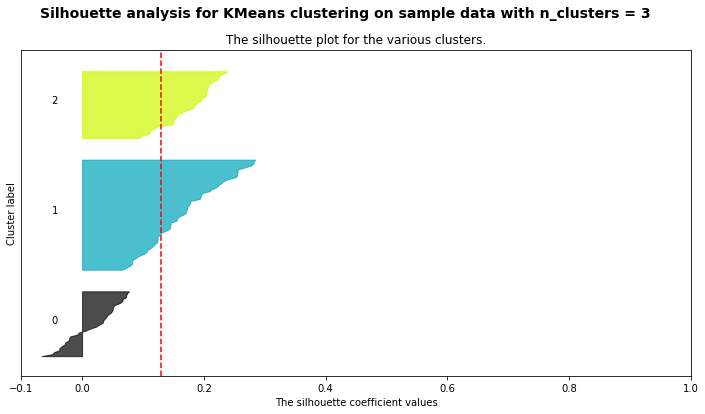

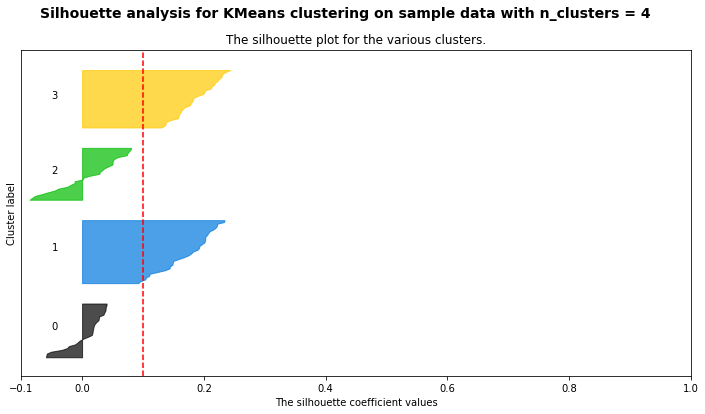

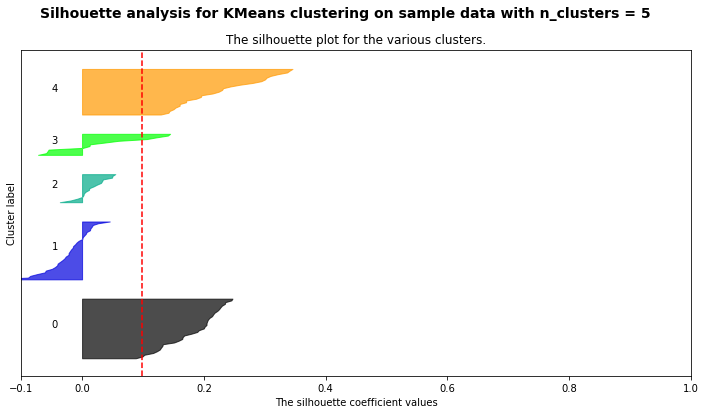

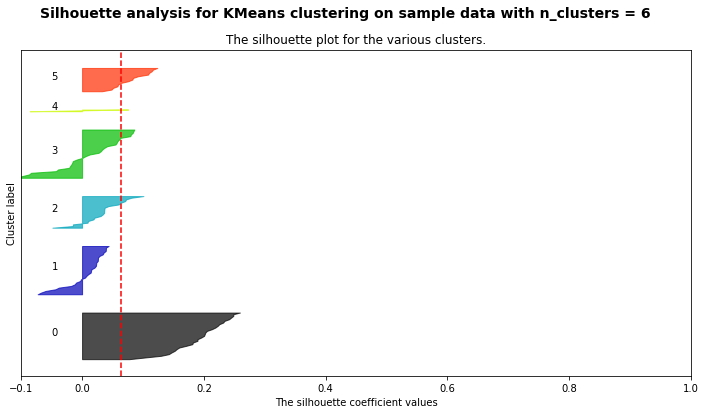

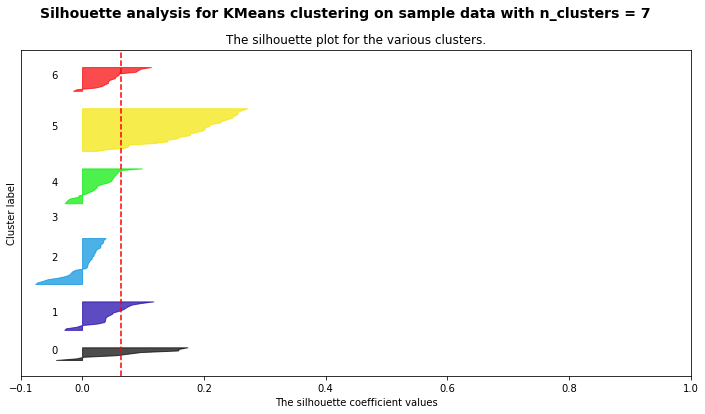

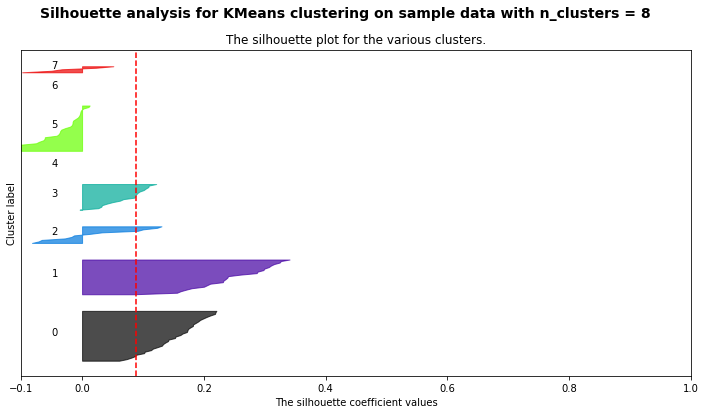

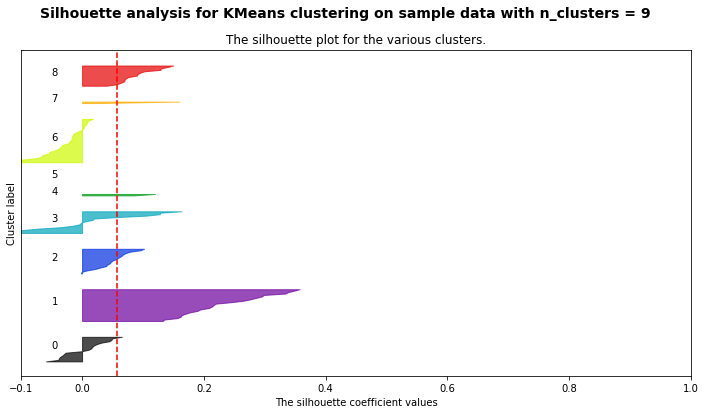

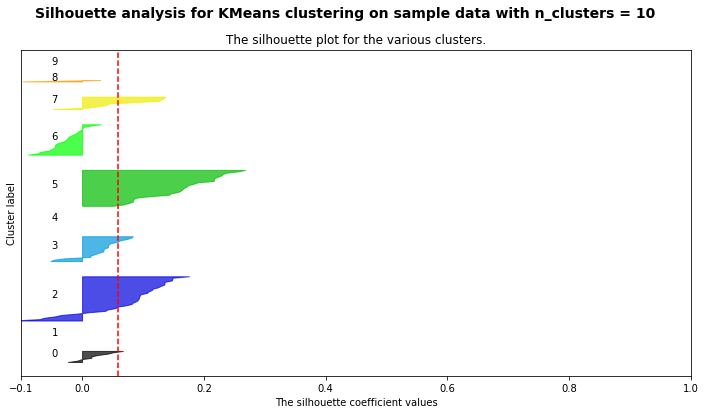

Number of clusters  Average silhouette score  \
0                   2                  0.192337   
1                   3                  0.130165   
2                   4                  0.099273   
3                   5                  0.098520   
4                   6                  0.063230   
5                   7                  0.063291   
6                   8                  0.089134   
7                   9                  0.057879   
8                  10                  0.059841   

                                     Size of cluster  \
0                                     {1: 38, 0: 88}   
1                              {2: 35, 1: 57, 0: 34}   
2                       {1: 35, 3: 32, 0: 30, 2: 29}   
3                {0: 35, 4: 27, 1: 34, 3: 13, 2: 17}   
4          {5: 15, 0: 29, 1: 30, 2: 20, 3: 30, 4: 2}   
5    {1: 19, 5: 28, 2: 30, 6: 16, 0: 9, 4: 23, 3: 1}   
6  {0: 34, 1: 24, 5: 31, 2: 12, 3: 18, 4: 1, 7: 5...   
7  {0: 18, 1: 23, 6: 31, 8: 15, 3: 16, 4: 2, 2: 1...   
8  {2: 33, 5: 27, 6: 23, 0: 9, 7: 10, 3: 19, 8: 2...   

                                  Label assignements  
0  [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, ...  
1  [2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 0, 1, 0, ...  
2  [1, 3, 0, 1, 1, 0, 3, 0, 1, 3, 1, 3, 2, 3, 2, ...  
3  [0, 4, 1, 0, 0, 1, 3, 1, 0, 4, 0, 4, 3, 4, 3, ...  
4  [5, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 0, 3, 0, 3, ...  
5  [1, 5, 2, 6, 6, 2, 0, 2, 6, 5, 1, 5, 0, 5, 0, ...  
6  [0, 1, 5, 0, 0, 5, 2, 5, 0, 1, 0, 1, 2, 1, 2, ...  
7  [0, 1, 6, 8, 8, 6, 3, 6, 8, 3, 4, 1, 3, 1, 3, ...  
8  [2, 5, 6, 2, 2, 6, 0, 0, 2, 0, 2, 0, 7, 0, 7, ...

In [33]:
# Convert DataFrame to matrix
fullProcessDataMat = fullProcessData.as_matrix()
# Standardise the data
fullProcessDataMat = preprocessing.scale(fullProcessDataMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
fullProcessDataResults = tryKmeans(fullProcessDataMat, rangeNbClusters=[2, 3, 4, 5, 6, 7, 8, 9, 10])
# Format results as a DataFrame
fullProcessDataResults = pd.DataFrame(data=fullProcessDataResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])
fullProcessDataResults

Conclusion: The data can be clustered in two groups or three groups (29/05/18)

Will split columns into 23 groups


FloatProgress(value=0.0, max=23.0)

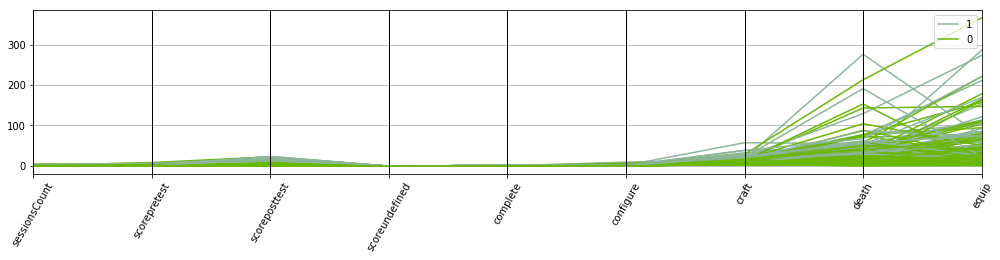

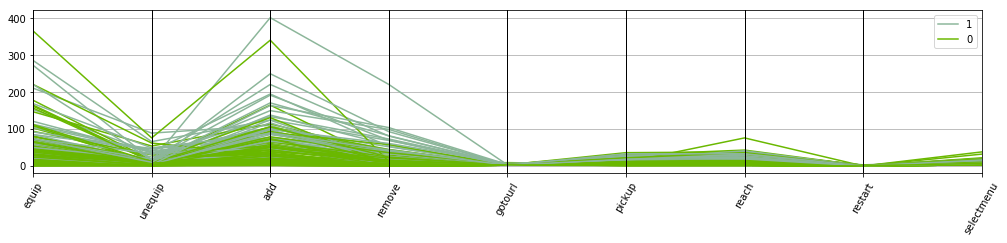

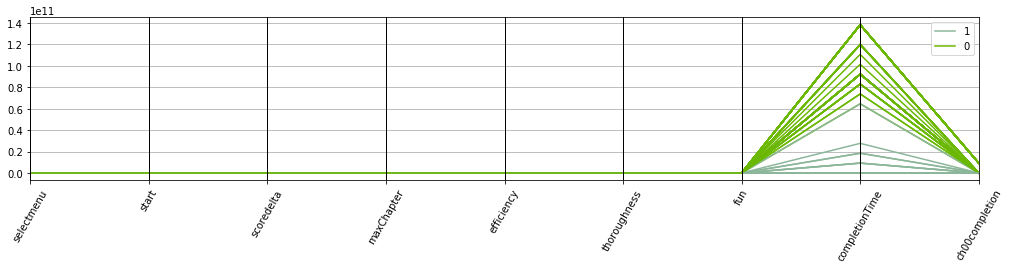

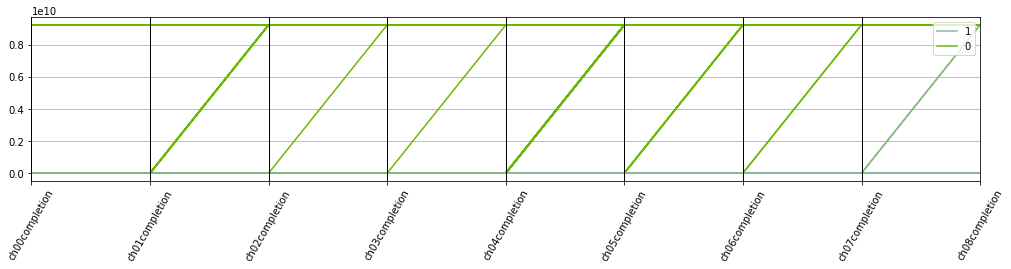

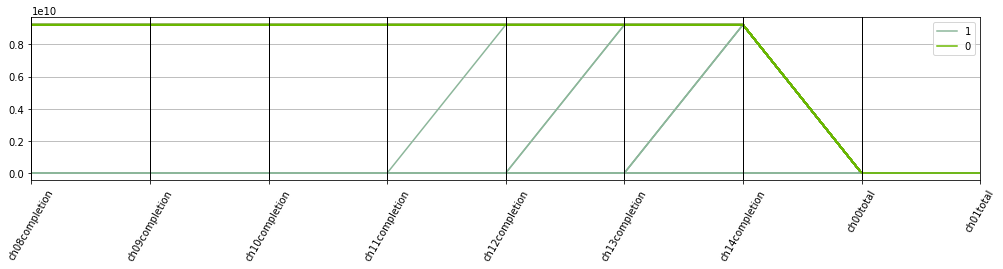

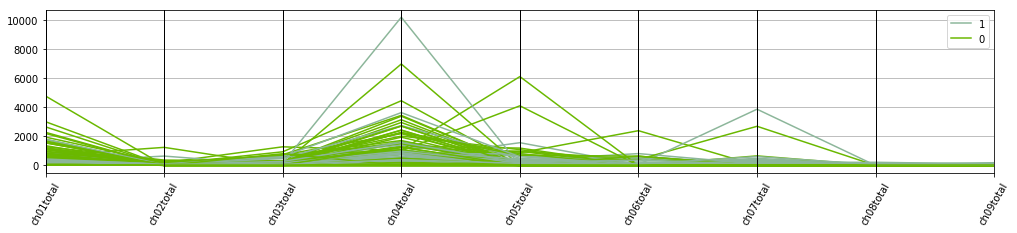

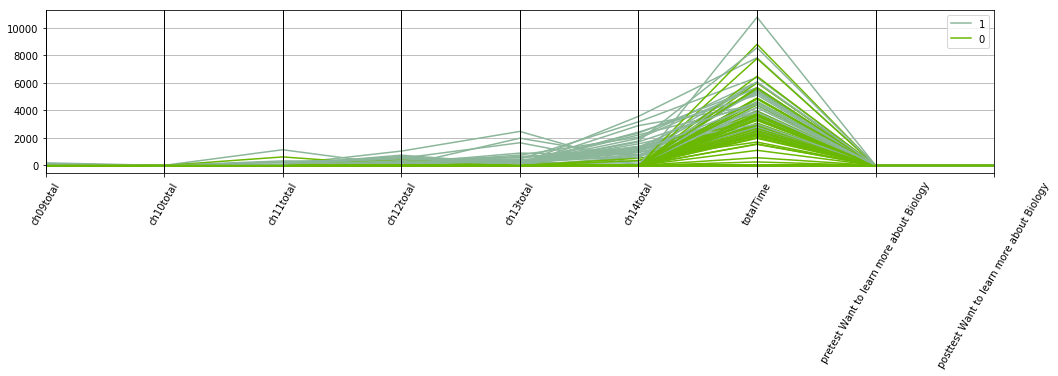

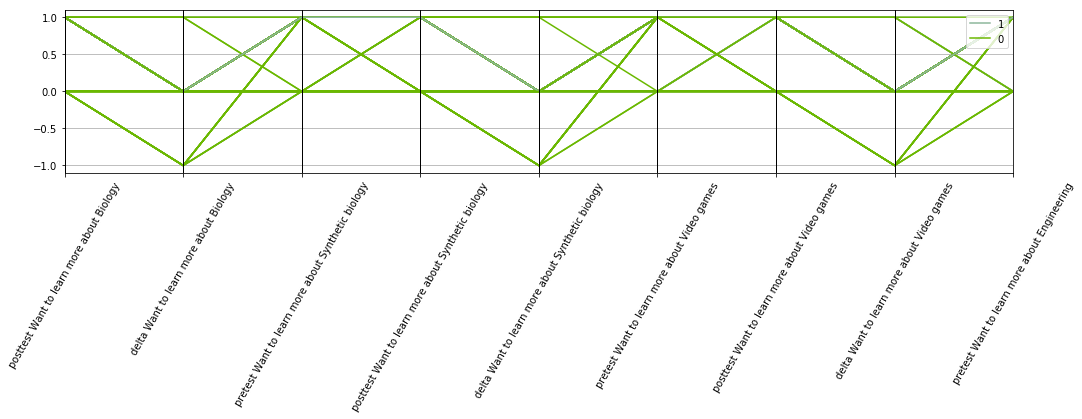

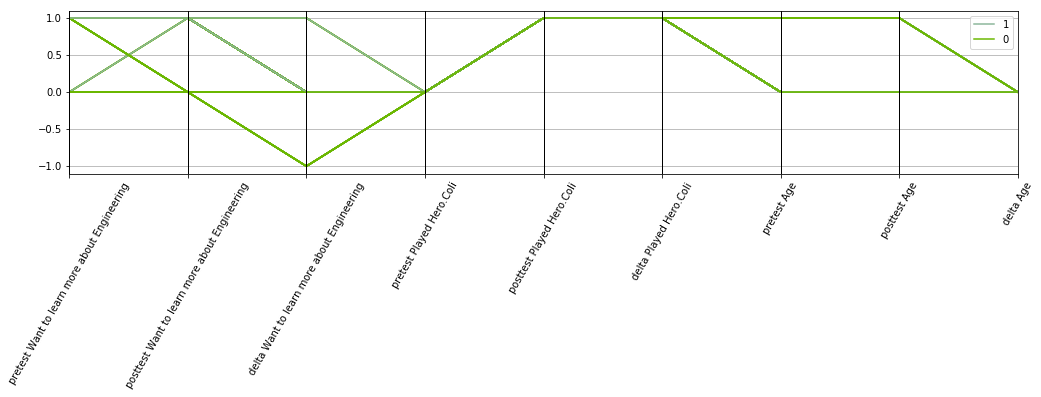

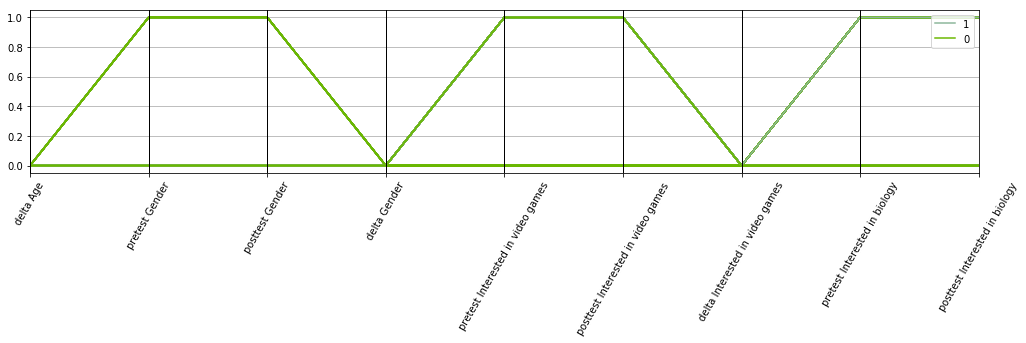

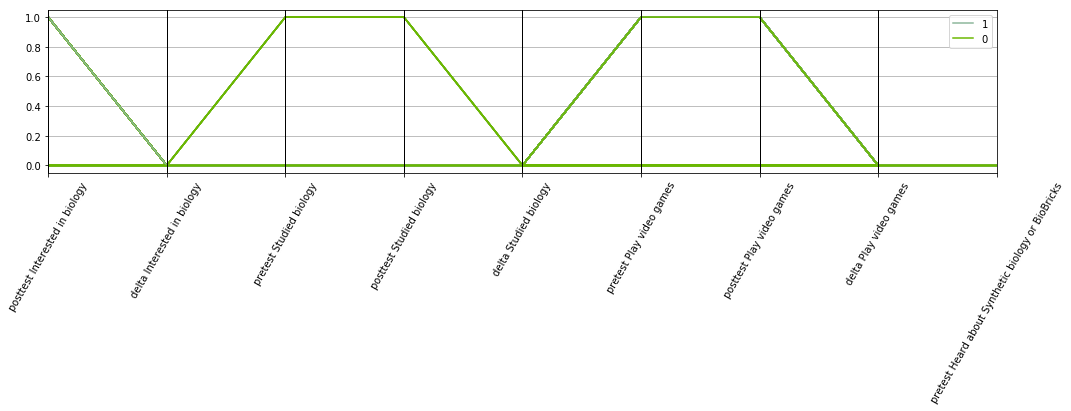

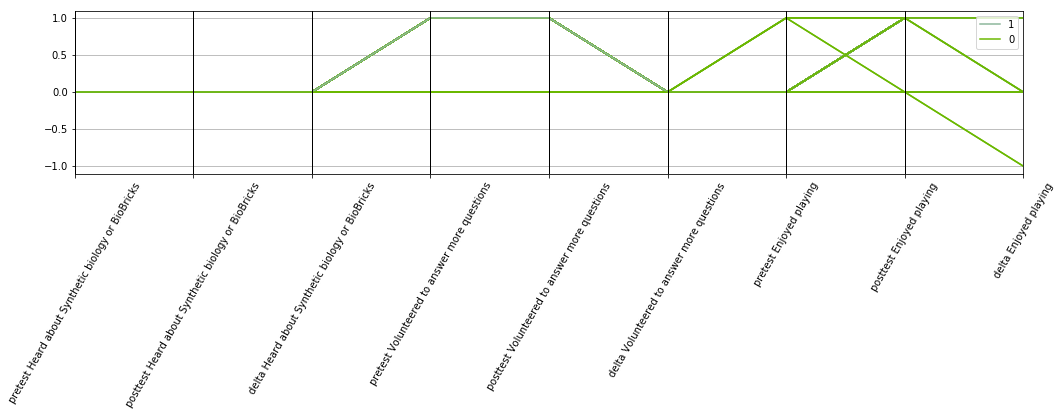

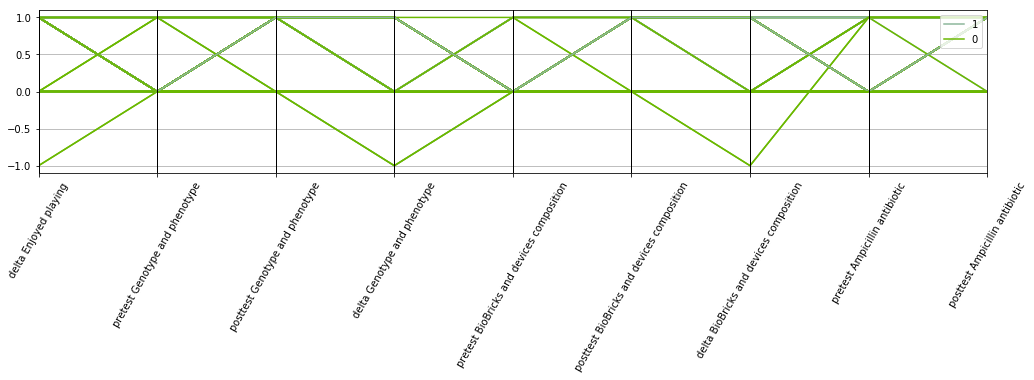

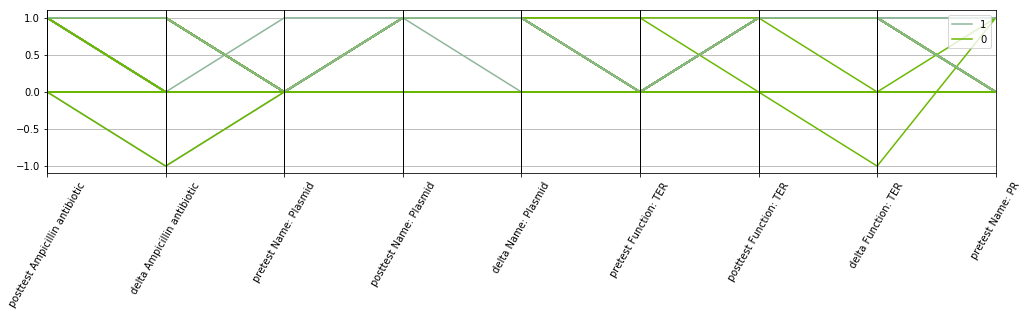

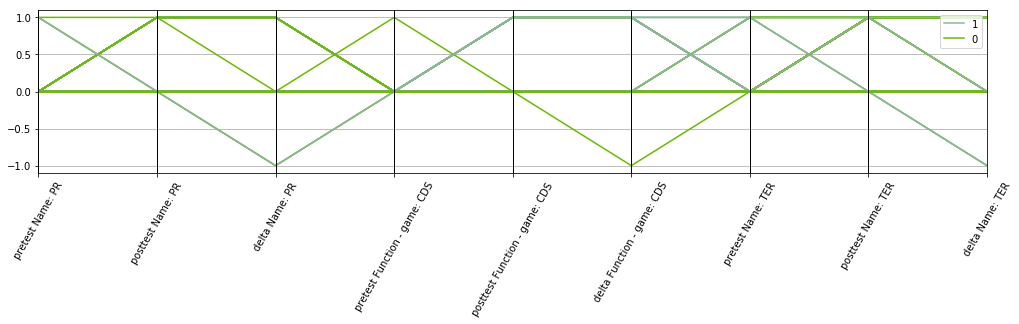

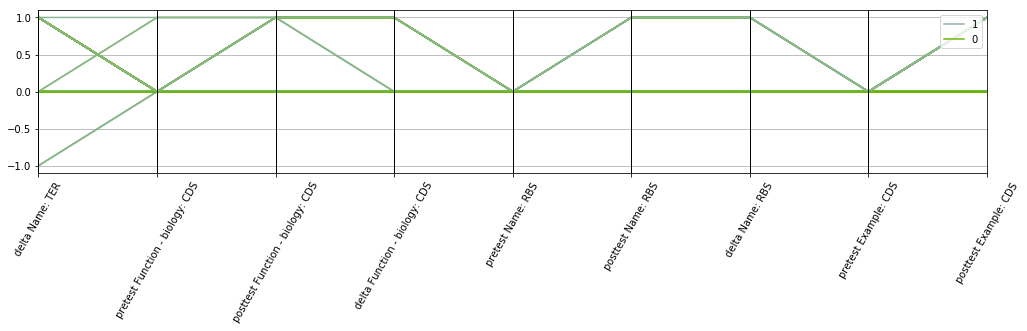

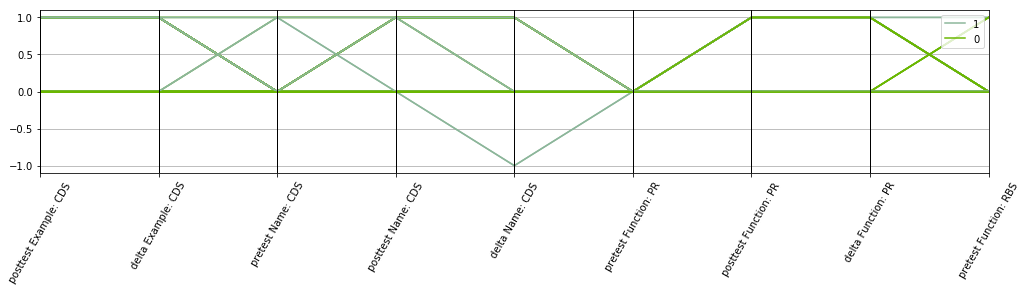

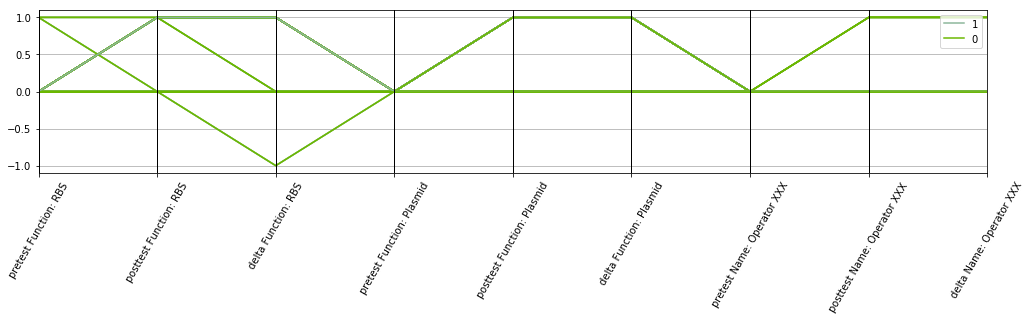

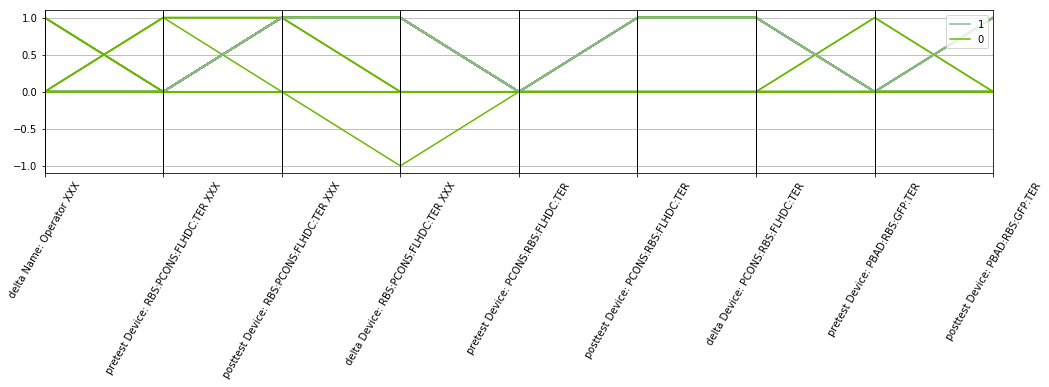

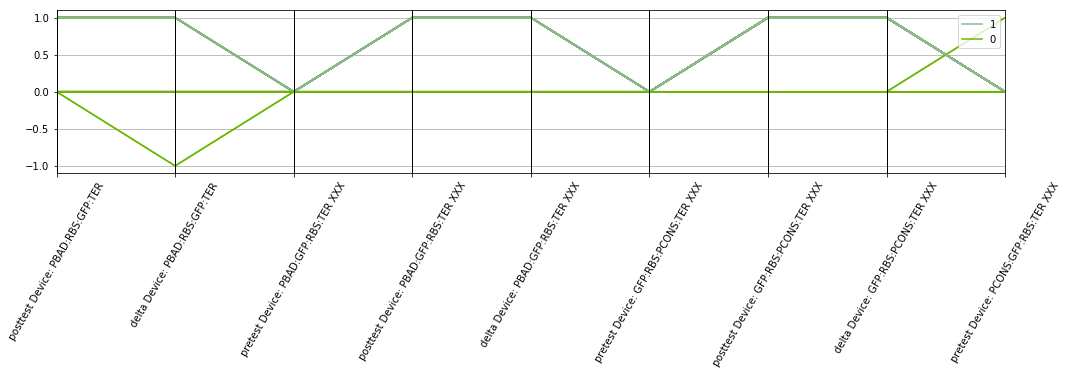

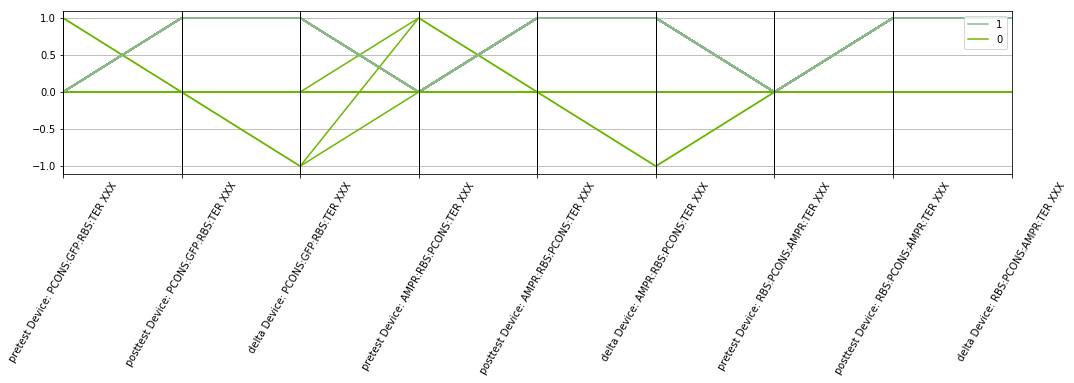

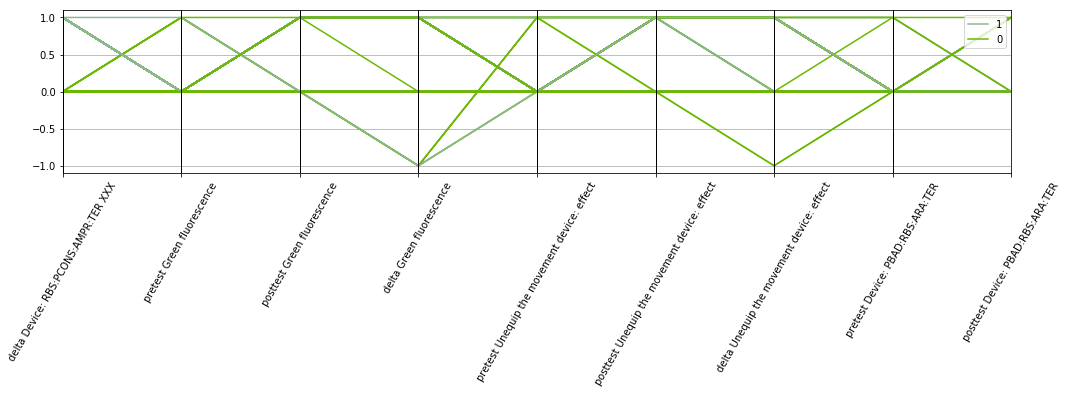

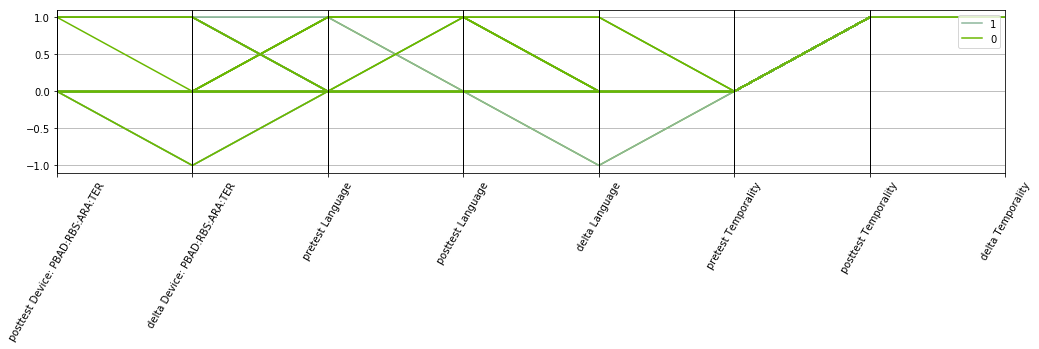

In [34]:
assignements = detailsKmeans(fullProcessData, fullProcessDataResults, 2, displayParallelCoord=True)

In [35]:
# Compute frequency of different levels of scores for each group
scores_before = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scorepretest")
scores_after = freqByCluster(fullProcessData, fullProcessDataResults, 2, "scoreposttest")

Ttest_indResult(statistic=-1.9262908908352494, pvalue=0.0563566428645697)
Ttest_indResult(statistic=-9.939626611747908, pvalue=1.7724633979059725e-17)


In [36]:
# Compare groups for behaviors
freqByCluster(fullProcessData, fullProcessDataResults, 2, "configure")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "craft")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "equip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "death")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "add")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "unequip")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "remove")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "pickup")
freqByCluster(fullProcessData, fullProcessDataResults, 2, "reach")

Ttest_indResult(statistic=0.3860508601351918, pvalue=0.7001205712634075)
Ttest_indResult(statistic=-9.765423797621448, pvalue=4.686241408010759e-17)
Ttest_indResult(statistic=-2.591308583197455, pvalue=0.0107078082042624)
Ttest_indResult(statistic=-3.6808920707322, pvalue=0.0003452683312501455)
Ttest_indResult(statistic=-6.6039341913869904, pvalue=1.0534921399257155e-09)
Ttest_indResult(statistic=-4.029978785063303, pvalue=9.66524055337768e-05)
Ttest_indResult(statistic=-8.132349745426248, pvalue=3.6957890608271226e-13)
Ttest_indResult(statistic=-9.22619155778088, pvalue=9.374082197450144e-16)
Ttest_indResult(statistic=-6.484988785774978, pvalue=1.9030266059087665e-09)


Cluster 0  Cluster 1
0.0    0.011364   0.000000
2.0    0.204545   0.000000
3.0    0.011364   0.000000
4.0    0.056818   0.000000
5.0    0.102273   0.000000
6.0    0.034091   0.000000
7.0    0.079545   0.000000
8.0    0.034091   0.000000
9.0    0.079545   0.000000
10.0   0.022727   0.000000
11.0   0.056818   0.000000
12.0   0.045455   0.000000
13.0   0.022727   0.026316
14.0   0.022727   0.000000
15.0   0.022727   0.000000
16.0   0.011364   0.000000
17.0   0.022727   0.078947
18.0   0.000000   0.026316
19.0   0.045455   0.105263
20.0   0.000000   0.157895
21.0   0.000000   0.052632
22.0   0.011364   0.131579
23.0   0.022727   0.052632
24.0   0.000000   0.052632
25.0   0.000000   0.052632
26.0   0.000000   0.026316
28.0   0.000000   0.026316
29.0   0.011364   0.000000
30.0   0.000000   0.026316
31.0   0.000000   0.052632
33.0   0.000000   0.052632
34.0   0.011364   0.026316
36.0   0.011364   0.000000
38.0   0.022727   0.000000
39.0   0.000000   0.026316
41.0   0.000000   0.026316
43.0   0.011364   0.000000
76.0   0.011364   0.000000

Conclusion: Clusters in two groups with different behaviours and scores! (29/05/18)
TODO RAPHAEL: Check clusters (2 groups and 3 clusters)

# Can the data be clustered according to the RedMetrics and the answers to the after questionnaire?

## If scientific questions are coded by answers

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


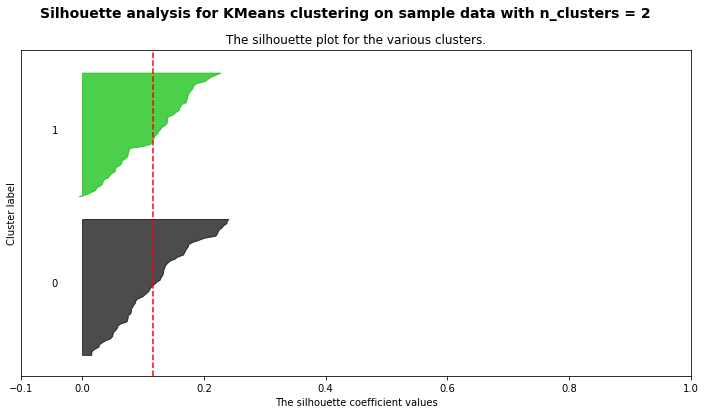

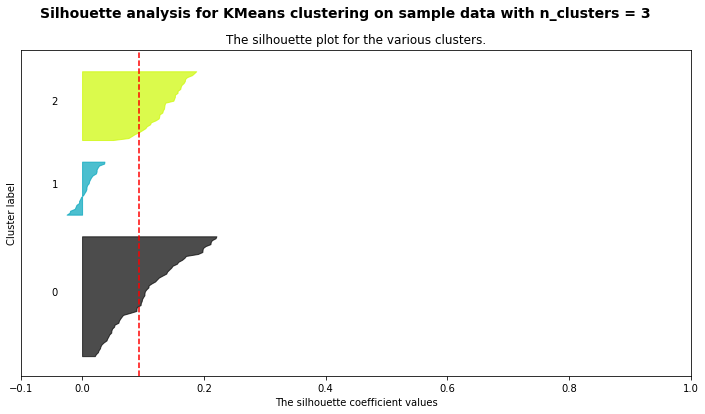

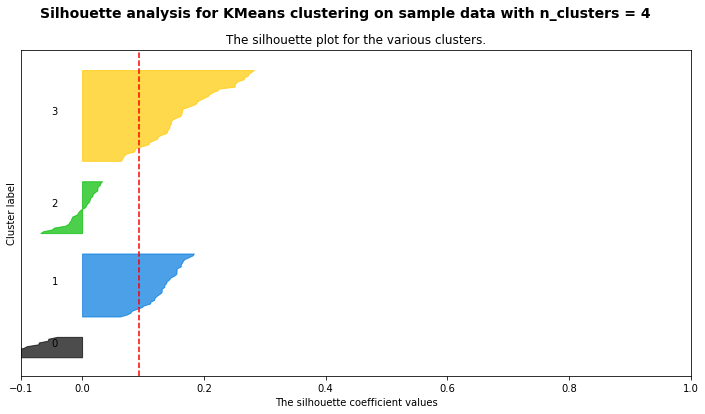

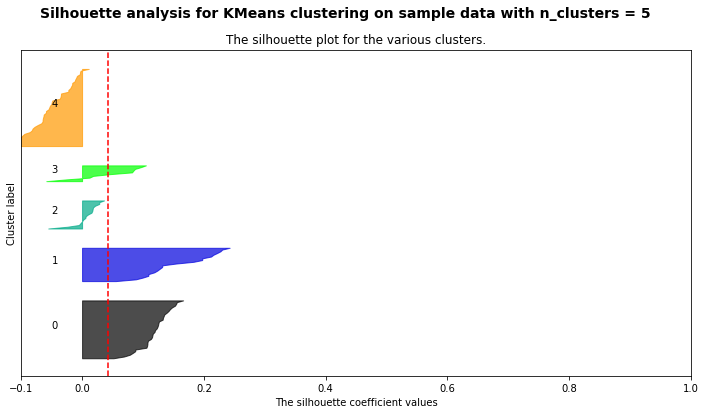

In [37]:
# Convert DataFrame to matrix
gameAndAfterMat = gameAndAfterData.as_matrix()
# Standardise the data
gameAndAfterMat = preprocessing.scale(gameAndAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndAfterResults = tryKmeans(gameAndAfterMat)
# Format results as a DataFrame
gameAndAfterResults = pd.DataFrame(data=gameAndAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: Two-clustering (29/05/18)

## If scientific questions are coded by correctedness

C:\Users\Mikael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Mikael\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


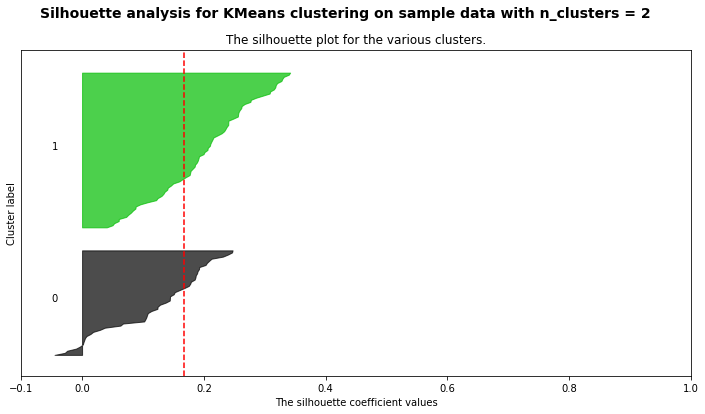

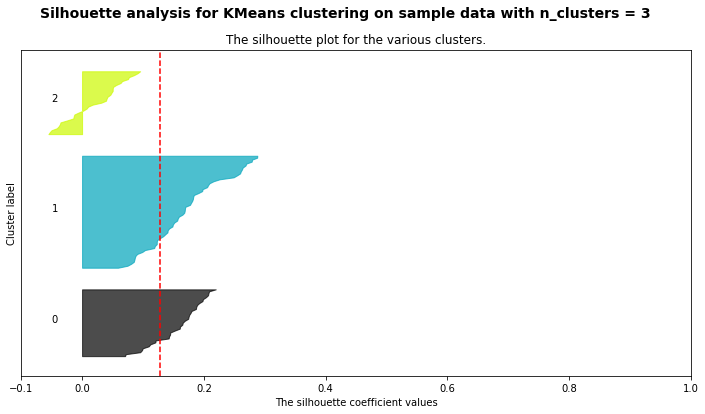

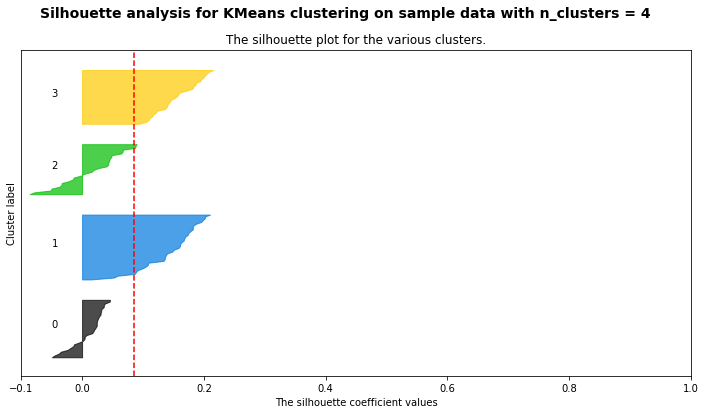

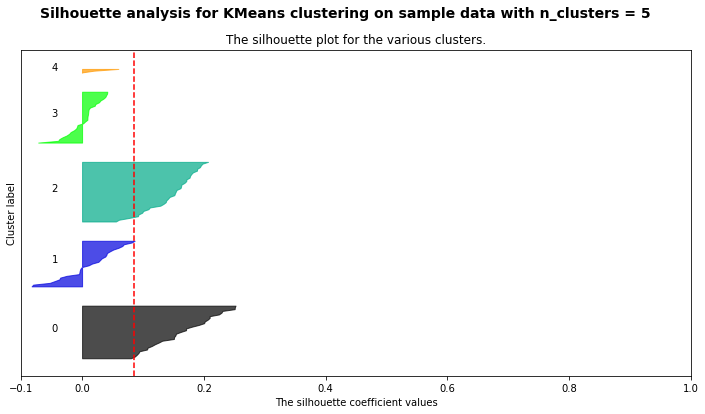

In [38]:
# Convert DataFrame to matrix
gameAndCorrectedAfterMat = gameAndCorrectedAfterData.as_matrix()
# Standardise the data
gameAndCorrectedAfterMat = preprocessing.scale(gameAndCorrectedAfterMat)
# Cluster using KMeans, and silhouette analysis to evaluate the pertinence of the clusters
gameAndCorrectedAfterResults = tryKmeans(gameAndCorrectedAfterMat)
# Format results as a DataFrame
gameAndCorrectedAfterResults = pd.DataFrame(data=gameAndCorrectedAfterResults, columns=['Number of clusters', 'Average silhouette score', 'Size of cluster', 'Label assignements'])

Conclusion: No interesting clustering (19/12/2017)

In [39]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "allScience")
correctAnswersByCluster

Cluster 0  Cluster 1
QGenotypePhenotype             0.960784   0.666667
QBioBricksDevicesComposition   0.803922   0.346667
QAmpicillin                    0.901961   0.386667
QBBNamePlasmid                 0.470588   0.186667
QBBFunctionTER                 0.705882   0.213333
QBBNamePromoter                0.333333   0.146667
QBBFunctionGameCDS             0.333333   0.040000
QBBNameTerminator              0.705882   0.306667
QBBFunctionBiologyCDS          0.352941   0.066667
QBBNameRBS                     0.176471   0.093333
QBBExampleCDS                  0.490196   0.186667
QBBNameCDS                     0.274510   0.120000
QBBFunctionPR                  0.313725   0.093333
QBBFunctionRBS                 0.764706   0.173333
QBBFunctionPlasmid             0.686275   0.146667
QBBNameOperator                0.058824   0.053333
QDeviceRbsPconsFlhdcTer        1.000000   0.360000
QDevicePconsRbsFlhdcTer        0.647059   0.146667
QDevicePbadRbsGfpTer           0.392157   0.066667
QDevicePbadGfpTbsTer           0.627451   0.120000
QDeviceGfpRbsPconsTer          0.921569   0.200000
QDevicePconsGfpRbsTer          0.568627   0.080000
QDeviceAmprRbsPconsTer         0.882353   0.186667
QDeviceRbsPconsAmprTer         0.960784   0.226667
QGreenFluorescence             0.901961   0.426667
QUnequipDevice                 0.862745   0.320000
QDevicePbadRbsAraTer           0.235294   0.053333

In [40]:
stats.ttest_ind(correctAnswersByCluster["Cluster 0"], correctAnswersByCluster["Cluster 1"])

Ttest_indResult(statistic=6.6885031185526405, pvalue=1.5530819110974882e-08)

In [41]:
# Compute score and compare clusters
gameAndCorrectedAfterData["sum"] = gameAndCorrectedAfterData.loc[:,"QGenotypePhenotype":"QDevicePbadRbsAraTer"].sum(axis=1)
scorePerCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "sum")
scorePerCluster

Ttest_indResult(statistic=16.027022650662957, pvalue=5.278910932062603e-32)


Cluster 0  Cluster 1
0    0.000000   0.066667
1    0.000000   0.093333
2    0.000000   0.120000
3    0.000000   0.053333
4    0.000000   0.133333
5    0.019608   0.093333
6    0.000000   0.120000
7    0.000000   0.066667
8    0.000000   0.040000
9    0.019608   0.053333
10   0.000000   0.026667
11   0.019608   0.040000
12   0.078431   0.040000
13   0.098039   0.026667
14   0.098039   0.013333
15   0.058824   0.000000
16   0.078431   0.013333
17   0.078431   0.000000
18   0.156863   0.000000
19   0.137255   0.000000
20   0.039216   0.000000
21   0.058824   0.000000
22   0.019608   0.000000
23   0.039216   0.000000

In [42]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityVideoGames")
correctAnswersByCluster

Ttest_indResult(statistic=2.114483262877627, pvalue=0.03647630081705843)


Cluster 0  Cluster 1
1   0.058824   0.066667
2   0.078431   0.213333
3   0.176471   0.160000
4   0.196078   0.280000
5   0.490196   0.280000

In [43]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityBiology")
correctAnswersByCluster

Ttest_indResult(statistic=5.177877156296405, pvalue=8.792466911016803e-07)


Cluster 0  Cluster 1
1   0.000000   0.133333
2   0.039216   0.240000
3   0.372549   0.320000
4   0.392157   0.280000
5   0.196078   0.026667

In [44]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "gameInterest")
correctAnswersByCluster

Ttest_indResult(statistic=2.257088697722492, pvalue=0.025752559893049917)


Cluster 0  Cluster 1
1   0.058824   0.080000
2   0.098039   0.213333
3   0.058824   0.186667
4   0.392157   0.226667
5   0.392157   0.293333

In [45]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QEnjoyed")
correctAnswersByCluster

Ttest_indResult(statistic=5.386626835777894, pvalue=3.469303957565621e-07)


Cluster 0  Cluster 1
-1   0.000000   0.013333
 0   0.000000   0.106667
 1   0.039216   0.266667
 2   0.333333   0.346667
 3   0.529412   0.240000
 4   0.098039   0.026667

In [46]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriositySyntheticBiology")
correctAnswersByCluster

Ttest_indResult(statistic=5.983575740698939, pvalue=2.1767693760061518e-08)


Cluster 0  Cluster 1
1   0.019608   0.200000
2   0.058824   0.253333
3   0.333333   0.333333
4   0.411765   0.200000
5   0.176471   0.013333

In [47]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QCuriosityEngineering")
correctAnswersByCluster

Ttest_indResult(statistic=5.47454414920188, pvalue=2.3305550677033996e-07)


Cluster 0  Cluster 1
1   0.019608   0.173333
2   0.098039   0.240000
3   0.215686   0.293333
4   0.254902   0.213333
5   0.411765   0.080000

In [48]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "gameFrequency")
correctAnswersByCluster

Ttest_indResult(statistic=1.7775830061773263, pvalue=0.0779237230270768)


Cluster 0  Cluster 1
1   0.078431   0.093333
2   0.117647   0.240000
3   0.176471   0.266667
4   0.372549   0.173333
5   0.254902   0.226667

In [49]:
#Compute frequency of correct answers for each group and each question
correctAnswersByCluster = freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "QVolunteer")
correctAnswersByCluster

Ttest_indResult(statistic=5.066891378545301, pvalue=1.4290675990412254e-06)


Cluster 0  Cluster 1
0   0.058824       0.44
1   0.941176       0.56

In [50]:
# Compare groups for behaviors
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "configure")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "craft")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "equip")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "death")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "add")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "unequip")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "remove")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "pickup")
freqByCluster(gameAndCorrectedAfterData, gameAndCorrectedAfterResults, 2, "reach")

Ttest_indResult(statistic=-0.29865548281698523, pvalue=0.7657028383028213)
Ttest_indResult(statistic=7.801767157881617, pvalue=2.1657447266432483e-12)
Ttest_indResult(statistic=1.8917188760465973, pvalue=0.06086077426986279)
Ttest_indResult(statistic=3.568349565982322, pvalue=0.0005116964968574719)
Ttest_indResult(statistic=5.315486079756453, pvalue=4.774205899699462e-07)
Ttest_indResult(statistic=3.320938808060482, pvalue=0.001178824329381144)
Ttest_indResult(statistic=6.465240423231479, pvalue=2.0983624750801246e-09)
Ttest_indResult(statistic=8.321310118846194, pvalue=1.3328701730257234e-13)
Ttest_indResult(statistic=5.648239139558184, pvalue=1.0509818634143711e-07)


Cluster 0  Cluster 1
0.0    0.000000   0.013333
2.0    0.019608   0.226667
3.0    0.000000   0.013333
4.0    0.000000   0.066667
5.0    0.019608   0.106667
6.0    0.000000   0.040000
7.0    0.000000   0.093333
8.0    0.000000   0.040000
9.0    0.019608   0.080000
10.0   0.019608   0.013333
11.0   0.019608   0.053333
12.0   0.019608   0.040000
13.0   0.039216   0.013333
14.0   0.019608   0.013333
15.0   0.019608   0.013333
16.0   0.000000   0.013333
17.0   0.098039   0.000000
18.0   0.019608   0.000000
19.0   0.098039   0.040000
20.0   0.117647   0.000000
21.0   0.039216   0.000000
22.0   0.098039   0.013333
23.0   0.039216   0.026667
24.0   0.039216   0.000000
25.0   0.039216   0.000000
26.0   0.019608   0.000000
28.0   0.019608   0.000000
29.0   0.000000   0.013333
30.0   0.019608   0.000000
31.0   0.039216   0.000000
33.0   0.039216   0.000000
34.0   0.039216   0.000000
36.0   0.000000   0.013333
38.0   0.000000   0.026667
39.0   0.019608   0.000000
41.0   0.019608   0.000000
43.0   0.000000   0.013333
76.0   0.000000   0.013333

Conclusion: 2-clustering by answers and game behaviour. Biggest differences in profile are in curiosity and gaming profile, unlike when clustering on just answers where biology level is a more significant difference (29/05/18)